# Pneumonia Diagnosis Using CNNs
___
Flatiron Data Science <br>
Phase 4 Project

**Author:** Evan Holder<br>
**[GitHub Link]()**<br>
**[Presentation Link]()**
<table><tr>
<td><img src="chest_xray/train/NORMAL/NORMAL2-IM-1423-0001.jpeg" style="width:380px;height:400px"/></td>
<td><img src= "chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg" style="width:380px;height:400px"/></td>
</tr></table>

## Overview
___
Pneumonia is a lung infection that affects people of all ages with varying degrees of severity. In fact,the CDC reports that in 2018 about 1.5 million people were diagnosed with pneumonia and more than 40,000 of those people died. For children, pneumonia is the most infectious cause of death worldwide. in 2019, 740,180 children under the age of 5 died of pneumonia according to the WHO.  While pneumonia is prevalent and deadly in populations across the world, its also treatable with the proper diagnosis.  For this reason, it's important that the infection is correctly identified so that it can be treated with low-cost and low-tech medication.  

## Business Problem
___
While pneumonia is diagnosable with symptoms and clinical features, chest x-rays remain the "gold standard" for confirming diagnosis of the infection.  Not only are x-rays widely available, but they're also relatively inexpensive and can be reviewed remotely.  With the advent of machine learning, it is possible to further decrease the cost of pneumonia diagnosis through identification of a pneumonia infection by way of convolutional neural networks.  Hospitals or general practices could administer X-rays and subsequently feed the images into a trained CNN to identify pneumonia without the need for a trained physician and/or simply use it to support a diagnosis. Once in use, this CNN would help lower the cost for both healthcare providers and patients themselves.


## Data Understanding
___
The data for this model comes from the [Kaggle dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) which originates from [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2).  X-rays are grayscale image data, so our model will be limitied to training on a single channel.

In [116]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from keras import layers, models, regularizers
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.applications import Xception
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, 
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)

import PIL
import os
import cv2 as cv
import math
import winsound

Here I'll just set up an alarm.  Since it takes variable amounts of time to complete a model, I'll want some notification that training is complete so that I can check the results of the models without wasting a lot time.

In [2]:
# Set up alarm for notification of model completion
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

Now, lets identify the directory paths that contain the data we'll be using.  After that I'll explore how much data we have.

In [9]:
# Identify data directories
data_train ='chest_xray/train'
data_test = 'chest_xray/test'
data_val = 'chest_xray/val'

In [3]:
# Get the files in each directory
train_norm =  [file for file in os.listdir('chest_xray/train/NORMAL') if file.endswith('jpeg')]
train_pneum =  [file for file in os.listdir('chest_xray/train/PNEUMONIA') if file.endswith('jpeg')]
test_norm =  [file for file in os.listdir('chest_xray/test/NORMAL') if file.endswith('jpeg')]
test_pneum =  [file for file in os.listdir('chest_xray/test/PNEUMONIA') if file.endswith('jpeg')]
val_norm =  [file for file in os.listdir('chest_xray/val/NORMAL') if file.endswith('jpeg')]
val_pneum =  [file for file in os.listdir('chest_xray/val/PNEUMONIA') if file.endswith('jpeg')]

# Print amount of data in each directory
tot = len(train_norm) + len(train_pneum) +len(test_norm) + len(test_pneum) + len(val_norm) + len(val_pneum)
print('Number of train images (normal):', len(train_norm))
print('Number of train images (pneumonia):', len(train_pneum))
print('Percentage of train images:', round((len(train_pneum)+ len(train_norm))/ tot, 3))


print('Number of test images (normal):', len(test_norm))
print('Number of test images (pneumonia):', len(test_pneum))
print('Percentage of test images:', round((len(test_pneum)+ len(test_norm))/ tot,3))


print('Number of validation images (normal):', len(val_norm))
print('Number of validation images (pneumonia):', len(val_pneum))
print('Percentage of val images:', round((len(val_pneum)+ len(val_norm))/ tot,3))

Number of train images (normal): 1341
Number of train images (pneumonia): 3875
Percentage of train images: 0.891
Number of test images (normal): 234
Number of test images (pneumonia): 390
Percentage of test images: 0.107
Number of validation images (normal): 8
Number of validation images (pneumonia): 8
Percentage of val images: 0.003


Only 16 images are included in the validation data. That's really not enough images to confidently evaluate the model and tweak accordingly.  Instead, we'll split the data into 75% training, 15% testing, and 15% validation. I will call the testing set, the tuning set from now on.  The validation set is our hold-out set to be used for evaluation of the final model.

Next, I'll move 824 images (412 normal, 412 pneumonia) from training set into the tuning and validation sets to create the 75-15-15 percent splits. That would be 254 images to the tuning set, and 862 images to the validation set.

In [4]:
# Get first 127 images of training_normal and training pneumonia
train_normal_127 = train_norm[:127]
train_pneumonia_127 = train_pneum[:127]
train_normal_431 = train_norm[127:558]
train_pneumonia_431 = train_pneum[127:558]

# Move these image from their testing folders to the respective validation folders
for file in train_normal_127:
    os.replace('chest_xray/train/NORMAL/{}'.format(file), 'chest_xray/test/NORMAL/{}'.format(file))
for file in train_pneumonia_127:
    os.replace('chest_xray/train/PNEUMONIA/{}'.format(file), 'chest_xray/test/PNEUMONIA/{}'.format(file))
for file in train_normal_431:
    os.replace('chest_xray/train/NORMAL/{}'.format(file), 'chest_xray/val/NORMAL/{}'.format(file))
for file in train_pneumonia_431:
    os.replace('chest_xray/train/PNEUMONIA/{}'.format(file), 'chest_xray/val/PNEUMONIA/{}'.format(file))

Below, I'll check that we moved the images to the correct folders and print the new portions of images in each set.

In [139]:
train_norm =  [file for file in os.listdir('chest_xray/train/NORMAL') if file.endswith('jpeg')]
train_pneum =  [file for file in os.listdir('chest_xray/train/PNEUMONIA') if file.endswith('jpeg')]
tune_norm =  [file for file in os.listdir('chest_xray/test/NORMAL') if file.endswith('jpeg')]
tune_pneum =  [file for file in os.listdir('chest_xray/test/PNEUMONIA') if file.endswith('jpeg')]
val_norm =  [file for file in os.listdir('chest_xray/val/NORMAL') if file.endswith('jpeg')]
val_pneum =  [file for file in os.listdir('chest_xray/val/PNEUMONIA') if file.endswith('jpeg')]

print('Number of train images (normal):', len(train_norm))
print('Number of train images (pneumonia):', len(train_pneum))
print('Percentage of train images:', round((len(train_pneum)+ len(train_norm))/ tot, 3))


print('Number of tuning images (normal):', len(tune_norm))
print('Number of tuning images (pneumonia):', len(tune_pneum))
print('Percentage of tuning images:', round((len(tune_pneum)+ len(tune_norm))/ tot,3))


print('Number of validation images (normal):', len(val_norm))
print('Number of validation images (pneumonia):', len(val_pneum))
print('Percentage of val images:', round((len(val_pneum)+ len(val_norm))/ tot,3))

Number of train images (normal): 783
Number of train images (pneumonia): 3317
Percentage of train images: 0.7
Number of tuning images (normal): 361
Number of tuning images (pneumonia): 517
Percentage of tuning images: 0.15
Number of validation images (normal): 439
Number of validation images (pneumonia): 439
Percentage of val images: 0.15


Next, let's check the class balance for each data set:

In [140]:
train_pneum_num = len(train_pneum)
tune_pneum_num = len(tune_pneum)
val_pnem_num = len(val_pneum)
train_norm_num = len(train_norm)
tune_norm_num = len(tune_norm)
val_norm_num = len(val_norm)

print('Training Class Balance:', round(train_pneum_num/(train_pneum_num+train_norm_num), 3))
print('Tuning Class Balance:', round(tune_pneum_num/(tune_pneum_num+tune_norm_num),3))
print('Val Class Balance:', round(val_pnem_num/(val_pnem_num+val_norm_num),3))

Training Class Balance: 0.809
Tuning Class Balance: 0.589
Val Class Balance: 0.5


The training data contains more pneumonia images that normal images.  Both the tuning and validation data have closer to 50% class balances.  For training, an 80% pneumonia images means our NN will learn patterns for pneumonia better than for normal x-rays.  The chance that the model classifies as pneumonia will be higher than that of normal, but this is okay.  In healthcare, we would rather ID the patient as having pneumonia and treating them for pneumonia even though they did not have. There is less harm in a false positive than a false negative. In the opposite case, the patient would have pneumonia but would receive no care because the model classified them as normal.

## Helper Functions
___
As we iterate on through models, need a few functions to help us improve on the model.

`visualize_training_results()` - Logs the history of each model and plot it with a line plot

In [6]:
def visualize_training_results(history):
    '''
    Plot training and tuning loss and accuracy for each model in a line plot
    
    PARAMETERS
    ----------
    history - history object containing model history
    '''
    history=history.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

`add_results()` - Given the model for which to evaluate, this funciton will calculate performance metrics and add them to a dataframe

In [7]:
def add_results(model, name):
    '''
    Add model precision, recall, accuracy, and f1-score to results dataframe.
    
    PARAMETERS
    ----------
    model - trained keras model
    name - string, name of the model
    '''
    preds = model.predict(tuning_gen)
    preds[preds>=.5]=1
    preds[preds<.5]=0
    precision = round(precision_score(tuning_gen.labels, preds),2)
    recall = round(recall_score(tuning_gen.labels, preds), 2)
    f1 = round(f1_score(tuning_gen.labels, preds),2)
    accuracy = accuracy_score(tuning_gen.labels, preds)
    results.loc[name, ['precision', 'recall', 'f1', 'accuracy']] = [precision, recall, f1, accuracy]

`train_model()` - function we'll call to actually train the model since there are few things we'll want to keep the same each time we run it.
* Checkpoints - We'll make a checkpoint using keras callbacks.  This checkpoint will check the accuracy of the model after each epoch and save the weights if the accuracy is better than all other epochs so far.  Using this checkpoint we'll be able to save the weights of the model that give the best accuracy and minimize our chance of overfitting on the training data.
* Compile - We'll compile the model in the same way each time, except include parameters so that we can change the loss and optimizers if desired.
* Fit - We'll call the fit method to fit the model on the training data and run the tuning data through validation_data parameter
* After the model is finished training, well reload the weights of the best epoch of training and save the model
* Visualize the training results - call our new `visualize_training_results()` function
* Print the classification report, and add the performance metrics to the results df

<u>Note:</u> The evaluation metric was included as changeable parameter. For this project I'll use accuracy throughout the entirety of the modeling process. I would like to keep our evaluation metric consistent so that models are comparable. Accuracy is the metric of choice because the goal is binary classification and we would like to maximize the number of correctly identifiied pneumonia patients.

In [8]:
def train_model(name, model, loss, optimizer, train_gen, tuning_gen, metric, epochs):
    '''
    Train a model, visualize the results, and save the model.
    
    PARAMETERS
    ----------
    name - string, name of the model
    model - keras model, the model itself
    loss - string, loss function
    optimizer - string, optimizer for model compiling
    train_gen - ImageDataGenerator, training data
    tuning_gen - ImageDataGenerator, tuning data
    metric - string, metric to evaluate model on
    epochs - int, number of epochs to train model for
    
    RETURNS
    -------
    Trained keras model
    '''
    
    # Create checkpoint to save model weights if this epoch's accuracy is the best so far
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='checkpoints/',
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        save_weights_only=True)
    
    # Compile the model
    model.compile(loss=loss, 
                   optimizer=optimizer,
                   metrics=['acc'])
    
    # Fit the model
    history = model.fit(train_gen,
                        validation_data=tuning_gen,
                        epochs=epochs,
                        callbacks=[checkpoint])
    
    # Reload weights of the best training epoch then save that model
    model.load_weights('checkpoints/')
    model.save('models/{}'.format(name))
    
    # Delete contents in checkpoints folder
    for file in os.listdir('checkpoints/'):
        os.remove('checkpoints/{}'.format(file))
        
    # Visualize training results
    visualize_training_results(history)
    
    # Print Classification report
    preds = model.predict(tuning_gen)
    preds[preds>=.5]=1
    preds[preds<.5]=0
    print(classification_report(tuning_gen.labels, preds, target_names=['normal', 'pneumonia']))
        
    # Add performance metrics to the results df
    add_results(model, name)
    
    # Beep to notify end of training
    winsound.Beep(freq, duration)
    return model

Lastly, we'll need to instantiate the results dataframe and create a folder for our model checkpoints to save.

In [9]:
# Create results dataframe
results = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

# Create checkpoints folder to log model weights
os.mkdir('checkpoints')

## Modeling
___

**$M_0$ - Baseline Model**

Here we'll set up the initial baseline architecture.
* Conv2D layers: 16-32-64 
* Dense layers: 100-1

In [ ]:
# get all the data in the directory split/test, and reshape them
size = (64, 64)
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation (200 images), and reshape them
tuning_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Epoch 1/10
205/205 [==============================] - 42s 202ms/step - loss: 0.5426 - acc: 0.7971 - val_loss: 0.6925 - val_acc: 0.5888
Epoch 2/10
205/205 [==============================] - 57s 277ms/step - loss: 0.5792 - acc: 0.8090 - val_loss: 0.6720 - val_acc: 0.5888
Epoch 3/10
205/205 [==============================] - 59s 284ms/step - loss: 0.4908 - acc: 0.8083 - val_loss: 0.6319 - val_acc: 0.5923
Epoch 4/10
205/205 [==============================] - 43s 212ms/step - loss: 0.3296 - acc: 0.8524 - val_loss: 0.7413 - val_acc: 0.6720
Epoch 5/10
205/205 [==============================] - 41s 200ms/step - loss: 0.2413 - acc: 0.9080 - val_loss: 0.5735 - val_acc: 0.7494
Epoch 6/10
205/205 [==============================] - 50s 244ms/step - loss: 0.1866 - acc: 0.9268 - val_loss: 0.4692 - val_acc: 0.8075
Epoch 7/10
205/205 [==============================] - 54s 266ms/step - loss: 0.1372 - acc: 0.9451 - val_loss: 0.6943 - val_acc: 0.7733
Epoch 8/10
205/205 [==============================] - 4

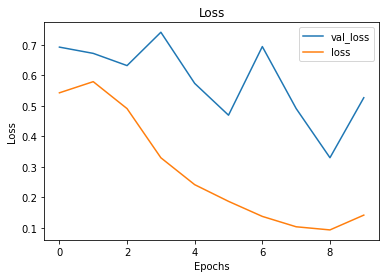

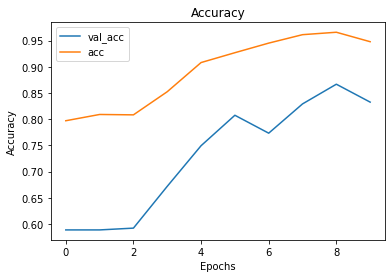

              precision    recall  f1-score   support

      normal       0.89      0.77      0.83       361
   pneumonia       0.85      0.93      0.89       517

    accuracy                           0.87       878
   macro avg       0.87      0.85      0.86       878
weighted avg       0.87      0.87      0.86       878



In [74]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(64,64, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(64,64, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', input_shape=(64,64, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_0',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u>
The intial model performed fairly well on our tuning data with ~87% accuracy.  The model is a bit overfit to the training data as the training/tuning accuracies differ by about 10%.  Additional training after the 9th epoch shows the tuning accuracy start to decrease. For the next model, let's try another optimizer.

**$M_1$ - Change optimizer to RMSprop**

Epoch 1/10
205/205 [==============================] - 45s 220ms/step - loss: 0.0942 - acc: 0.9649 - val_loss: 0.4496 - val_acc: 0.8554
Epoch 2/10
205/205 [==============================] - 45s 218ms/step - loss: 0.0825 - acc: 0.9720 - val_loss: 0.5226 - val_acc: 0.8474
Epoch 3/10
205/205 [==============================] - 48s 233ms/step - loss: 0.0852 - acc: 0.9673 - val_loss: 0.6915 - val_acc: 0.8189
Epoch 4/10
205/205 [==============================] - 45s 222ms/step - loss: 0.0683 - acc: 0.9732 - val_loss: 1.8078 - val_acc: 0.6902
Epoch 5/10
205/205 [==============================] - 51s 249ms/step - loss: 0.0713 - acc: 0.9715 - val_loss: 0.5289 - val_acc: 0.8554
Epoch 6/10
205/205 [==============================] - 45s 219ms/step - loss: 0.0621 - acc: 0.9754 - val_loss: 1.0971 - val_acc: 0.7916
Epoch 7/10
205/205 [==============================] - 41s 201ms/step - loss: 0.0698 - acc: 0.9751 - val_loss: 0.7129 - val_acc: 0.8383
Epoch 8/10
205/205 [==============================] - 4

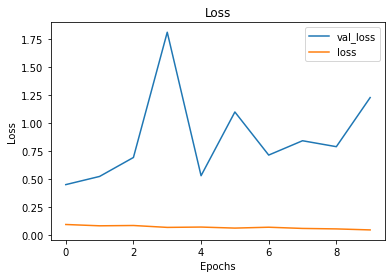

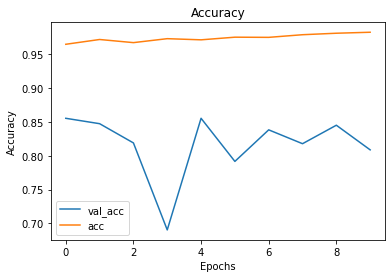

              precision    recall  f1-score   support

      normal       0.94      0.70      0.80       361
   pneumonia       0.82      0.97      0.89       517

    accuracy                           0.86       878
   macro avg       0.88      0.83      0.84       878
weighted avg       0.87      0.86      0.85       878



In [76]:
model = train_model(name='model_1',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.RMSprop(), 
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> Using the RMSprop optimizer did not work nearly as well as the adam optimizer since the training and tuning losses were all over the place instead of diminishing as we trained.  Lets go back to the adam optimizer.  For model_2, lets add some l2 regularizers to fix our overfitting issue.

**$M_2$ - Change back to the adam optimizer, add L2 regularization.**

Epoch 1/10
205/205 [==============================] - 41s 200ms/step - loss: 1.0486 - acc: 0.8090 - val_loss: 0.9025 - val_acc: 0.5888
Epoch 2/10
205/205 [==============================] - 41s 203ms/step - loss: 0.6320 - acc: 0.8090 - val_loss: 0.8185 - val_acc: 0.5888
Epoch 3/10
205/205 [==============================] - 47s 230ms/step - loss: 0.5762 - acc: 0.8090 - val_loss: 0.8717 - val_acc: 0.5888
Epoch 4/10
205/205 [==============================] - 49s 239ms/step - loss: 0.5457 - acc: 0.8090 - val_loss: 0.8313 - val_acc: 0.5888
Epoch 5/10
205/205 [==============================] - 47s 228ms/step - loss: 0.5320 - acc: 0.8090 - val_loss: 0.7330 - val_acc: 0.5888
Epoch 6/10
205/205 [==============================] - 43s 210ms/step - loss: 0.5339 - acc: 0.8090 - val_loss: 0.7888 - val_acc: 0.5888
Epoch 7/10
205/205 [==============================] - 43s 209ms/step - loss: 0.5186 - acc: 0.8090 - val_loss: 0.9127 - val_acc: 0.5888
Epoch 8/10
205/205 [==============================] - 4

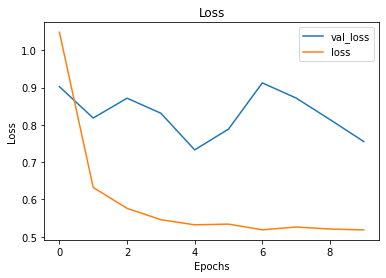

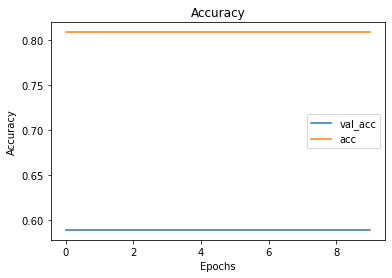

C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       361
   pneumonia       0.59      1.00      0.74       517

    accuracy                           0.59       878
   macro avg       0.29      0.50      0.37       878
weighted avg       0.35      0.59      0.44       878



In [86]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(64,64, 1), 
                        kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

model = train_model(name='model_2',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> $M_2$ appears to be over-regularized as the model did not improve at all through training. Let's decrease L2 from 0.01 to 0.0001

**$M_3$ - Modify regularization by decreasing L2 to 0.0001**

Epoch 1/10
205/205 [==============================] - 45s 219ms/step - loss: 0.5891 - acc: 0.8041 - val_loss: 0.6539 - val_acc: 0.5888
Epoch 2/10
205/205 [==============================] - 41s 201ms/step - loss: 0.4613 - acc: 0.8090 - val_loss: 0.6258 - val_acc: 0.5888
Epoch 3/10
205/205 [==============================] - 47s 231ms/step - loss: 0.3254 - acc: 0.8090 - val_loss: 0.6651 - val_acc: 0.5888
Epoch 4/10
205/205 [==============================] - 42s 206ms/step - loss: 0.2763 - acc: 0.8454 - val_loss: 0.5079 - val_acc: 0.7779
Epoch 5/10
205/205 [==============================] - 41s 201ms/step - loss: 0.1953 - acc: 0.9341 - val_loss: 0.5961 - val_acc: 0.7836
Epoch 6/10
205/205 [==============================] - 40s 196ms/step - loss: 0.2659 - acc: 0.9256 - val_loss: 0.4009 - val_acc: 0.8371
Epoch 7/10
205/205 [==============================] - 41s 200ms/step - loss: 0.2060 - acc: 0.9368 - val_loss: 0.6583 - val_acc: 0.7392
Epoch 8/10
205/205 [==============================] - 4

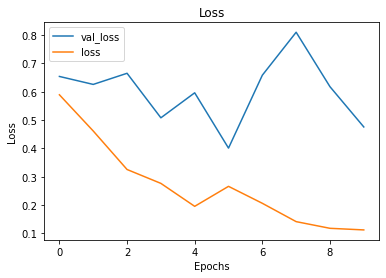

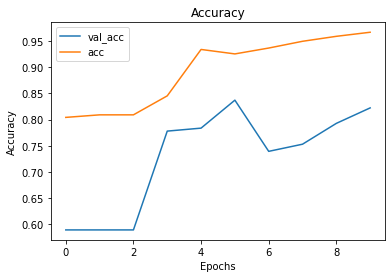

              precision    recall  f1-score   support

      normal       0.95      0.64      0.76       361
   pneumonia       0.79      0.97      0.88       517

    accuracy                           0.84       878
   macro avg       0.87      0.81      0.82       878
weighted avg       0.86      0.84      0.83       878



In [88]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(64,64, 1), 
                        kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))

model = train_model(name='model_3',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> $M_3$ is still overfitting and did not seem to improve the accuracy at all. Let's try changing up the architecture a bit by increasing the number of nodes in our dense layer to 512.

**$M_4$ - Increase Dense layer nodes from 100 to 512**

Epoch 1/10
205/205 [==============================] - 42s 205ms/step - loss: 0.5783 - acc: 0.8041 - val_loss: 0.6247 - val_acc: 0.5888
Epoch 2/10
205/205 [==============================] - 41s 201ms/step - loss: 0.3377 - acc: 0.8585 - val_loss: 0.3769 - val_acc: 0.8440
Epoch 3/10
205/205 [==============================] - 42s 206ms/step - loss: 0.2126 - acc: 0.9195 - val_loss: 0.4041 - val_acc: 0.8337
Epoch 4/10
205/205 [==============================] - 42s 207ms/step - loss: 0.2223 - acc: 0.9034 - val_loss: 0.5734 - val_acc: 0.7779
Epoch 5/10
205/205 [==============================] - 43s 212ms/step - loss: 0.1450 - acc: 0.9441 - val_loss: 0.4249 - val_acc: 0.8314
Epoch 6/10
205/205 [==============================] - 46s 227ms/step - loss: 0.1217 - acc: 0.9563 - val_loss: 0.7079 - val_acc: 0.7733
Epoch 7/10
205/205 [==============================] - 43s 210ms/step - loss: 0.1035 - acc: 0.9598 - val_loss: 0.9594 - val_acc: 0.7460
Epoch 8/10
205/205 [==============================] - 4

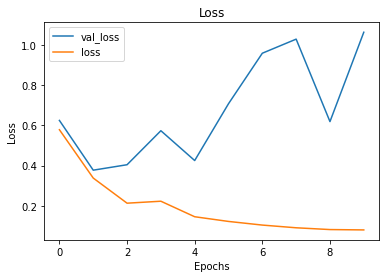

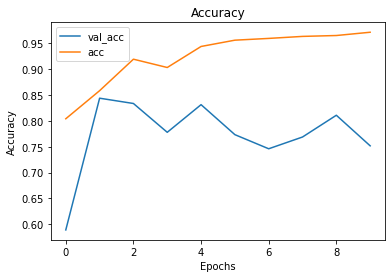

              precision    recall  f1-score   support

      normal       0.89      0.70      0.79       361
   pneumonia       0.82      0.94      0.88       517

    accuracy                           0.84       878
   macro avg       0.86      0.82      0.83       878
weighted avg       0.85      0.84      0.84       878



In [89]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(64,64, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_4',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> Increasing the model complexity might increase the accuracy with some more tweaking but its highly overfitting still.  Our image resolution in still pretty low, lets increase the input shape from (64,64) to (128, 128)

**$M_5$ - Increase image resolution to (128, 128)**

In [9]:
# get all the data in the directory split/test, and reshape them
size = (128, 128)
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation (200 images), and reshape them
tuning_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/10
205/205 [==============================] - 57s 273ms/step - loss: 0.5257 - acc: 0.8256 - val_loss: 0.8245 - val_acc: 0.5945
Epoch 2/10
205/205 [==============================] - 56s 274ms/step - loss: 0.2459 - acc: 0.9076 - val_loss: 0.4935 - val_acc: 0.8030
Epoch 3/10
205/205 [==============================] - 62s 303ms/step - loss: 0.1574 - acc: 0.9385 - val_loss: 0.7486 - val_acc: 0.7893
Epoch 4/10
205/205 [==============================] - 69s 335ms/step - loss: 0.1215 - acc: 0.9554 - val_loss: 0.7394 - val_acc: 0.7927
Epoch 5/10
205/205 [==============================] - 60s 295ms/step - loss: 0.1000 - acc: 0.9617 - val_loss: 0.6937 - val_acc: 0.7995
Epoch 6/10
205/205 [==============================] - 57s 275ms/step - loss: 0.0812 - acc: 0.9695 - val_loss: 0.5361 - val_acc: 0.8383
Epoch 7/10
205/205 [==============================] - 66s 323ms/step - loss: 0.1237 - acc: 0.9551 - val_loss: 0.5552 - val_acc: 0.8428
Epoch 8/10
205/205 [==============================] - 7

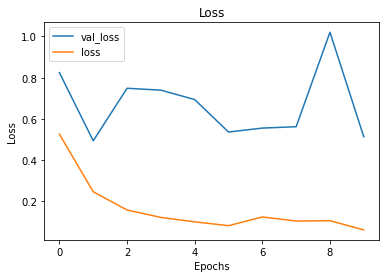

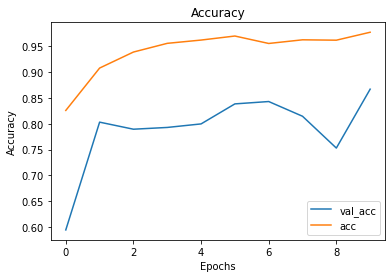

              precision    recall  f1-score   support

      normal       0.95      0.71      0.81       361
   pneumonia       0.83      0.97      0.90       517

    accuracy                           0.87       878
   macro avg       0.89      0.84      0.86       878
weighted avg       0.88      0.87      0.86       878



In [91]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_5',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> Finally we have a model that compares with $M_0$'s accuracy, however it is still drastically over fitting. Let's again try L2 regularization.

**$M_6$ - add L2 regularizers at 0.001**

Epoch 1/10
205/205 [==============================] - 69s 335ms/step - loss: 0.9448 - acc: 0.7846 - val_loss: 0.7915 - val_acc: 0.5888
Epoch 2/10
205/205 [==============================] - 62s 304ms/step - loss: 0.6092 - acc: 0.8241 - val_loss: 0.6197 - val_acc: 0.6913
Epoch 3/10
205/205 [==============================] - 61s 296ms/step - loss: 0.3938 - acc: 0.8793 - val_loss: 0.7136 - val_acc: 0.7187
Epoch 4/10
205/205 [==============================] - 68s 333ms/step - loss: 0.2904 - acc: 0.9122 - val_loss: 0.4762 - val_acc: 0.8269
Epoch 5/10
205/205 [==============================] - 65s 316ms/step - loss: 0.2519 - acc: 0.9285 - val_loss: 0.3987 - val_acc: 0.8576
Epoch 6/10
205/205 [==============================] - 64s 314ms/step - loss: 0.2122 - acc: 0.9444 - val_loss: 0.5598 - val_acc: 0.8109
Epoch 7/10
205/205 [==============================] - 65s 315ms/step - loss: 0.1954 - acc: 0.9461 - val_loss: 0.5353 - val_acc: 0.8018
Epoch 8/10
205/205 [==============================] - 6

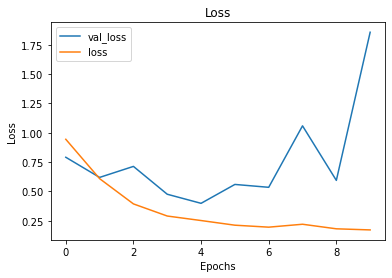

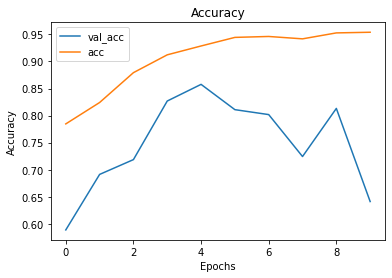

              precision    recall  f1-score   support

      normal       0.91      0.73      0.81       361
   pneumonia       0.83      0.95      0.89       517

    accuracy                           0.86       878
   macro avg       0.87      0.84      0.85       878
weighted avg       0.86      0.86      0.85       878



In [92]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.001)))

model = train_model(name='model_6',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> While this model did not improve on the accuracy, the regularization appears to work a little better. Looking at the plot of the loss function above, it's easy to see that after only 4 epochs val_loss starts to increase rather than decrease. Lets decrease the learning rate so we don't overshoot our solution.

**$M_7$ - Decrease learning_rate to 0.0005**

Epoch 1/10
205/205 [==============================] - 61s 295ms/step - loss: 0.9259 - acc: 0.7817 - val_loss: 2.5284 - val_acc: 0.5888
Epoch 2/10
205/205 [==============================] - 60s 295ms/step - loss: 0.6814 - acc: 0.8090 - val_loss: 0.8116 - val_acc: 0.5888
Epoch 3/10
205/205 [==============================] - 65s 316ms/step - loss: 0.4213 - acc: 0.8498 - val_loss: 0.5515 - val_acc: 0.7813
Epoch 4/10
205/205 [==============================] - 70s 342ms/step - loss: 0.3517 - acc: 0.9115 - val_loss: 0.7542 - val_acc: 0.7153
Epoch 5/10
205/205 [==============================] - 60s 292ms/step - loss: 0.2646 - acc: 0.9317 - val_loss: 0.4898 - val_acc: 0.8109
Epoch 6/10
205/205 [==============================] - 57s 277ms/step - loss: 0.2358 - acc: 0.9388 - val_loss: 1.2203 - val_acc: 0.6298
Epoch 7/10
205/205 [==============================] - 64s 313ms/step - loss: 0.2261 - acc: 0.9471 - val_loss: 0.6678 - val_acc: 0.7756
Epoch 8/10
205/205 [==============================] - 6

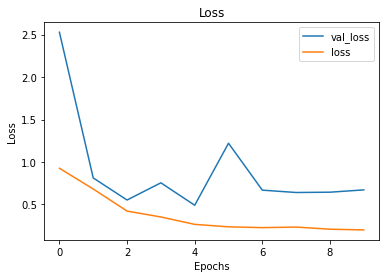

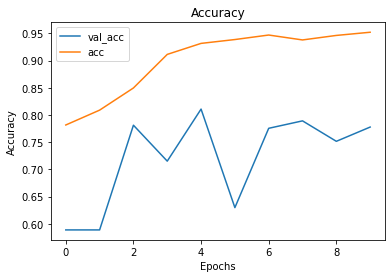

              precision    recall  f1-score   support

      normal       0.95      0.57      0.71       361
   pneumonia       0.77      0.98      0.86       517

    accuracy                           0.81       878
   macro avg       0.86      0.78      0.79       878
weighted avg       0.84      0.81      0.80       878



In [93]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.001)))

model = train_model(name='model_7',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> Decreasing the learning rate did help keep our loss metrics from fluctuating, but the val_accuracy itself is still fluctuating a decent amount shown in the above plot.  Let's add another form of regulatization through a dropout layer.

**$M_8$ - Add 10% dropout layer**

Epoch 1/10
205/205 [==============================] - 61s 297ms/step - loss: 0.8116 - acc: 0.7883 - val_loss: 0.8931 - val_acc: 0.5888
Epoch 2/10
205/205 [==============================] - 67s 329ms/step - loss: 0.4356 - acc: 0.8505 - val_loss: 0.7519 - val_acc: 0.6834
Epoch 3/10
205/205 [==============================] - 73s 355ms/step - loss: 0.3020 - acc: 0.9029 - val_loss: 0.6862 - val_acc: 0.7301
Epoch 4/10
205/205 [==============================] - 66s 324ms/step - loss: 0.2616 - acc: 0.9190 - val_loss: 0.7308 - val_acc: 0.7688
Epoch 5/10
205/205 [==============================] - 65s 317ms/step - loss: 0.2302 - acc: 0.9295 - val_loss: 0.6750 - val_acc: 0.7938
Epoch 6/10
205/205 [==============================] - 67s 327ms/step - loss: 0.2365 - acc: 0.9295 - val_loss: 0.6856 - val_acc: 0.7950
Epoch 7/10
205/205 [==============================] - 64s 313ms/step - loss: 0.2051 - acc: 0.9449 - val_loss: 0.4100 - val_acc: 0.8633
Epoch 8/10
205/205 [==============================] - 6

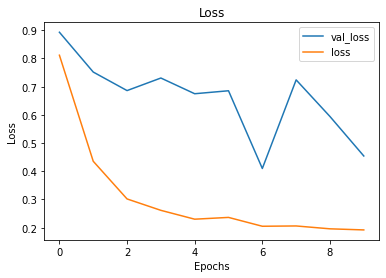

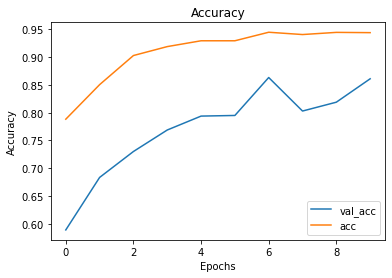

              precision    recall  f1-score   support

      normal       0.91      0.74      0.82       361
   pneumonia       0.84      0.95      0.89       517

    accuracy                           0.86       878
   macro avg       0.88      0.84      0.85       878
weighted avg       0.87      0.86      0.86       878



In [97]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.1))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.001)))

model = train_model(name='model_8',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> The model's val_accuracy is not longer fluctuating as we train through epochs, except once we start overfitting towards the end of training.  Lets make the model more complex and increase the dropout rate so that we again do not overfit too much.

**$M_8$ - Add another dense layer of 256, increase to 20% dropout layers**

Epoch 1/10
205/205 [==============================] - 56s 271ms/step - loss: 1.0178 - acc: 0.8046 - val_loss: 1.3070 - val_acc: 0.5888
Epoch 2/10
205/205 [==============================] - 85s 416ms/step - loss: 0.5732 - acc: 0.8324 - val_loss: 1.3411 - val_acc: 0.6002
Epoch 3/10
205/205 [==============================] - 72s 352ms/step - loss: 0.4512 - acc: 0.8983 - val_loss: 0.6725 - val_acc: 0.7677
Epoch 4/10
205/205 [==============================] - 64s 311ms/step - loss: 0.3000 - acc: 0.9344 - val_loss: 0.6799 - val_acc: 0.7984
Epoch 5/10
205/205 [==============================] - 64s 314ms/step - loss: 0.2610 - acc: 0.9437 - val_loss: 0.6236 - val_acc: 0.8155
Epoch 6/10
205/205 [==============================] - 76s 371ms/step - loss: 0.2355 - acc: 0.9483 - val_loss: 0.9404 - val_acc: 0.7517
Epoch 7/10
205/205 [==============================] - 69s 339ms/step - loss: 0.2309 - acc: 0.9488 - val_loss: 0.4227 - val_acc: 0.8702
Epoch 8/10
205/205 [==============================] - 6

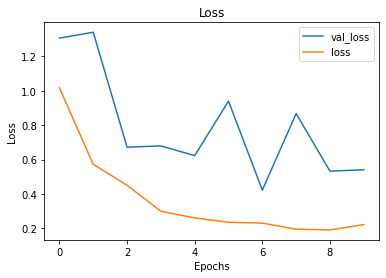

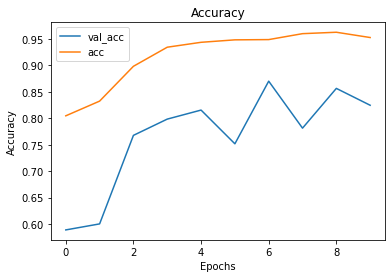

              precision    recall  f1-score   support

      normal       0.93      0.74      0.82       361
   pneumonia       0.84      0.96      0.90       517

    accuracy                           0.87       878
   macro avg       0.88      0.85      0.86       878
weighted avg       0.88      0.87      0.87       878



In [98]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.001)))

model = train_model(name='model_8',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> Our above model has finally improved upon the very first model, with an tuning accuracy of ~87%. The model seems to be getting better with higher resolution and then some regularization.  Let's follow this strategy and increase resolution to (256, 256) and subsequently add regularization.  Also, let's increase the batch size to get a better estimate on the error gradient (so long as the CPU can handle it).

**$M_9$ - increase resolution to (256, 256), remove regularization, increase batch_size**

In [11]:
# get all the data in the directory split/test, and reshape them
size = (256, 256)
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation (200 images), and reshape them
tuning_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/10
82/82 [==============================] - 150s 2s/step - loss: 0.6604 - acc: 0.7934 - val_loss: 0.5157 - val_acc: 0.7107
Epoch 2/10
82/82 [==============================] - 140s 2s/step - loss: 0.4746 - acc: 0.8520 - val_loss: 2.9794 - val_acc: 0.5888
Epoch 3/10
82/82 [==============================] - 144s 2s/step - loss: 0.3960 - acc: 0.8820 - val_loss: 0.5871 - val_acc: 0.7893
Epoch 4/10
82/82 [==============================] - 130s 2s/step - loss: 0.2708 - acc: 0.8954 - val_loss: 0.5059 - val_acc: 0.8030
Epoch 5/10
82/82 [==============================] - 147s 2s/step - loss: 0.1797 - acc: 0.9322 - val_loss: 0.8565 - val_acc: 0.7608
Epoch 6/10
82/82 [==============================] - 130s 2s/step - loss: 0.1323 - acc: 0.9507 - val_loss: 0.6092 - val_acc: 0.7836
Epoch 7/10
82/82 [==============================] - 146s 2s/step - loss: 0.1042 - acc: 0.9602 - val_loss: 0.6041 - val_acc: 0.8280
Epoch 8/10
82/82 [==============================] - 132s 2s/step - loss: 0.0664 - a

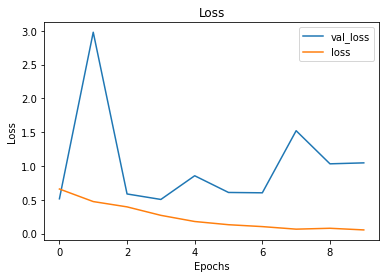

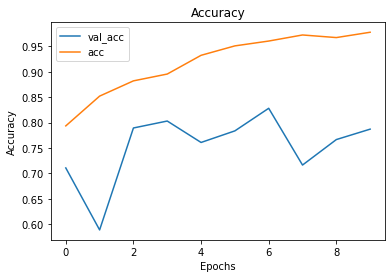

              precision    recall  f1-score   support

      normal       0.94      0.62      0.75       361
   pneumonia       0.79      0.97      0.87       517

    accuracy                           0.83       878
   macro avg       0.86      0.80      0.81       878
weighted avg       0.85      0.83      0.82       878



In [117]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_9',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> The model is overfitting to the training set, let's add regularization.

**$M_{10}$ - Add L2 regularization**

Epoch 1/10
82/82 [==============================] - 142s 2s/step - loss: 1.6325 - acc: 0.8090 - val_loss: 1.1305 - val_acc: 0.5888
Epoch 2/10
82/82 [==============================] - 151s 2s/step - loss: 0.9726 - acc: 0.8102 - val_loss: 1.3539 - val_acc: 0.5888
Epoch 3/10
82/82 [==============================] - 135s 2s/step - loss: 0.6264 - acc: 0.8237 - val_loss: 0.8050 - val_acc: 0.7005
Epoch 4/10
82/82 [==============================] - 143s 2s/step - loss: 0.5220 - acc: 0.8641 - val_loss: 0.6773 - val_acc: 0.7722
Epoch 5/10
82/82 [==============================] - 147s 2s/step - loss: 0.4807 - acc: 0.8710 - val_loss: 0.8058 - val_acc: 0.6913
Epoch 6/10
82/82 [==============================] - 132s 2s/step - loss: 0.4685 - acc: 0.8878 - val_loss: 0.7318 - val_acc: 0.7289
Epoch 7/10
82/82 [==============================] - 146s 2s/step - loss: 0.3948 - acc: 0.9020 - val_loss: 2.7636 - val_acc: 0.5888
Epoch 8/10
82/82 [==============================] - 134s 2s/step - loss: 0.6481 - a

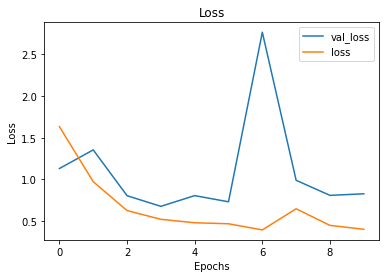

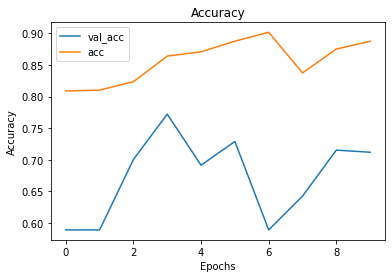

              precision    recall  f1-score   support

      normal       0.80      0.59      0.68       361
   pneumonia       0.76      0.90      0.82       517

    accuracy                           0.77       878
   macro avg       0.78      0.74      0.75       878
weighted avg       0.78      0.77      0.76       878



In [133]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256, 256, 1),
                       kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

model = train_model(name='model_9',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> Regularization prevented overfitting a little but did not improve the performance of the model. Let's rerun the model but remove regularization remove the 256 dense layer since we have a pretty complicated model.

**$M_{10}$** - remove regularization, and dense layer with 256 nodes.

Epoch 1/10
82/82 [==============================] - 126s 2s/step - loss: 0.9424 - acc: 0.7929 - val_loss: 0.8125 - val_acc: 0.6412
Epoch 2/10
82/82 [==============================] - 138s 2s/step - loss: 0.4795 - acc: 0.8441 - val_loss: 0.5696 - val_acc: 0.7472
Epoch 3/10
82/82 [==============================] - 122s 1s/step - loss: 0.4498 - acc: 0.8727 - val_loss: 0.4286 - val_acc: 0.8360
Epoch 4/10
82/82 [==============================] - 138s 2s/step - loss: 0.2315 - acc: 0.9041 - val_loss: 0.9282 - val_acc: 0.7312
Epoch 5/10
82/82 [==============================] - 123s 1s/step - loss: 0.1678 - acc: 0.9373 - val_loss: 0.3918 - val_acc: 0.8519
Epoch 6/10
82/82 [==============================] - 138s 2s/step - loss: 0.1123 - acc: 0.9544 - val_loss: 0.5390 - val_acc: 0.8166
Epoch 7/10
82/82 [==============================] - 128s 2s/step - loss: 0.1019 - acc: 0.9615 - val_loss: 1.2328 - val_acc: 0.7335
Epoch 8/10
82/82 [==============================] - 138s 2s/step - loss: 0.0794 - a

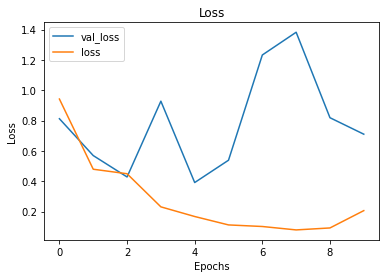

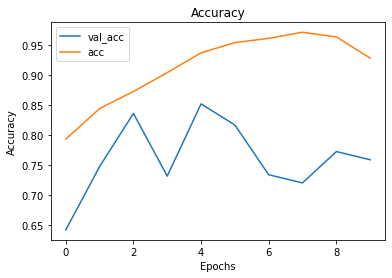

              precision    recall  f1-score   support

      normal       0.91      0.71      0.80       361
   pneumonia       0.83      0.95      0.88       517

    accuracy                           0.85       878
   macro avg       0.87      0.83      0.84       878
weighted avg       0.86      0.85      0.85       878



In [134]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_10',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> Model performance did improve, however still have drastic overfitting. Add regularization back in.

**$M_{11}$ - add regularization**

Epoch 1/10
82/82 [==============================] - 142s 2s/step - loss: 1.3823 - acc: 0.7237 - val_loss: 0.9216 - val_acc: 0.5888
Epoch 2/10
82/82 [==============================] - 142s 2s/step - loss: 1.0356 - acc: 0.8132 - val_loss: 0.7007 - val_acc: 0.7893
Epoch 3/10
82/82 [==============================] - 151s 2s/step - loss: 0.5145 - acc: 0.8278 - val_loss: 0.6645 - val_acc: 0.7483
Epoch 4/10
82/82 [==============================] - 134s 2s/step - loss: 0.4456 - acc: 0.8671 - val_loss: 0.7109 - val_acc: 0.7301
Epoch 5/10
82/82 [==============================] - 151s 2s/step - loss: 0.3038 - acc: 0.9229 - val_loss: 0.5724 - val_acc: 0.8189
Epoch 6/10
82/82 [==============================] - 145s 2s/step - loss: 0.3078 - acc: 0.9220 - val_loss: 0.9115 - val_acc: 0.7005
Epoch 7/10
82/82 [==============================] - 160s 2s/step - loss: 0.2529 - acc: 0.9373 - val_loss: 0.5153 - val_acc: 0.8246
Epoch 8/10
82/82 [==============================] - 168s 2s/step - loss: 0.2376 - a

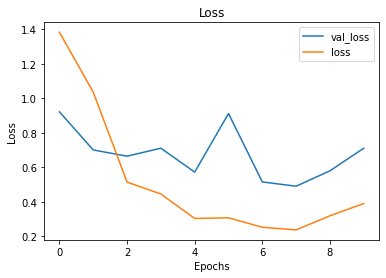

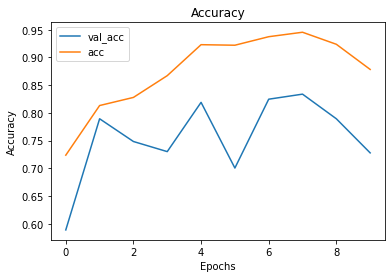

              precision    recall  f1-score   support

      normal       0.93      0.65      0.76       361
   pneumonia       0.80      0.97      0.87       517

    accuracy                           0.83       878
   macro avg       0.86      0.81      0.82       878
weighted avg       0.85      0.83      0.83       878



In [135]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256, 256, 1),
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.001)))

model = train_model(name='model_11',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> Model performance did not improve, and still have drastic overfitting.

$M_{8}$ was the best model so far with 87% accuracy and an F1 score of 0.9.  Lets go back to this model and see if we can improve on it.  Now, well add in some image augmentation techniques.

**$M_{12}$ - revert to $M_{8}$ and add image augmentation**
* rotation_range=15
* fill_mode=nearest
* width_shift_range=.1
* height_shift_range=.2
* brightness_range=[.8,1.2]

In [13]:
# get all the data in the directory split/test, and reshape them
size = (128,128)
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
tuning_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/10
205/205 [==============================] - 67s 326ms/step - loss: 1.0077 - acc: 0.8090 - val_loss: 0.8925 - val_acc: 0.5888
Epoch 2/10
205/205 [==============================] - 76s 373ms/step - loss: 0.6474 - acc: 0.8090 - val_loss: 1.0774 - val_acc: 0.5888
Epoch 3/10
205/205 [==============================] - 71s 347ms/step - loss: 0.6042 - acc: 0.8090 - val_loss: 0.8791 - val_acc: 0.5888
Epoch 4/10
205/205 [==============================] - 67s 329ms/step - loss: 0.5804 - acc: 0.8090 - val_loss: 0.8915 - val_acc: 0.5888
Epoch 5/10
205/205 [==============================] - 69s 336ms/step - loss: 0.5646 - acc: 0.8090 - val_loss: 0.7189 - val_acc: 0.5888
Epoch 6/10
205/205 [==============================] - 76s 369ms/step - loss: 0.5628 - acc: 0.8090 - val_loss: 0.7686 - val_acc: 0.5888
Epoch 7/10
205/205 [==============================] - 69s 338ms/step - loss: 0.5698 - acc: 0.8090 - val_loss: 0.7343 - val_acc: 0.5888
Epoch 8/10
205/205 [==============================] - 7

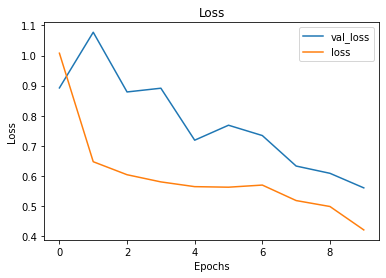

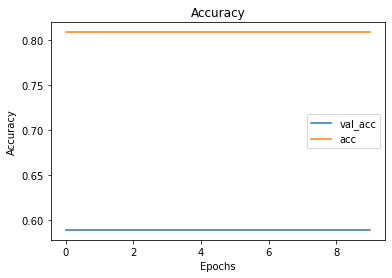

C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       361
   pneumonia       0.59      1.00      0.74       517

    accuracy                           0.59       878
   macro avg       0.29      0.50      0.37       878
weighted avg       0.35      0.59      0.44       878



In [138]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.001)))

model = train_model(name='model_12',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)


<u>Notes:</u> Model did not train, let's decrease the amount of L2 regularization.

**$M_{13}$ - decrease L2 regularization**

Epoch 1/10
205/205 [==============================] - 70s 339ms/step - loss: 0.5989 - acc: 0.8076 - val_loss: 0.7406 - val_acc: 0.5888
Epoch 2/10
205/205 [==============================] - 78s 380ms/step - loss: 0.5078 - acc: 0.8093 - val_loss: 0.5353 - val_acc: 0.6276
Epoch 3/10
205/205 [==============================] - 74s 361ms/step - loss: 0.4274 - acc: 0.8290 - val_loss: 0.8716 - val_acc: 0.6173
Epoch 4/10
205/205 [==============================] - 69s 335ms/step - loss: 0.3767 - acc: 0.8490 - val_loss: 0.9445 - val_acc: 0.6925
Epoch 5/10
205/205 [==============================] - 77s 376ms/step - loss: 0.3302 - acc: 0.8710 - val_loss: 0.8453 - val_acc: 0.7118
Epoch 6/10
205/205 [==============================] - 78s 381ms/step - loss: 0.3150 - acc: 0.8863 - val_loss: 0.3489 - val_acc: 0.8770
Epoch 7/10
205/205 [==============================] - 67s 328ms/step - loss: 0.2731 - acc: 0.9029 - val_loss: 0.4045 - val_acc: 0.8554
Epoch 8/10
205/205 [==============================] - 7

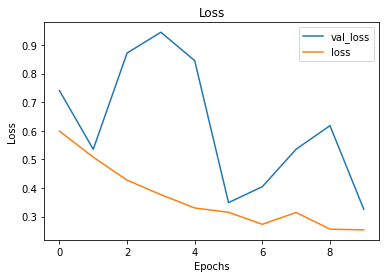

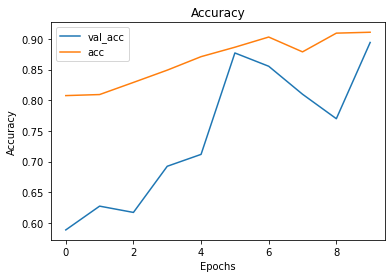

              precision    recall  f1-score   support

      normal       0.88      0.86      0.87       361
   pneumonia       0.90      0.92      0.91       517

    accuracy                           0.89       878
   macro avg       0.89      0.89      0.89       878
weighted avg       0.89      0.89      0.89       878



In [139]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.0001)))

model = train_model(name='model_13',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)


<u>Notes:</u> Great this is the best model yet.  The model achieved its highest accuracy in the last round of training.  Lets reload this model and continue to train it for 10 more epochs

**$M_{14}$ - load $M_{13}$ and continue training it for 10 more epochs**

Epoch 1/10
205/205 [==============================] - 69s 336ms/step - loss: 0.2508 - acc: 0.9151 - val_loss: 0.7661 - val_acc: 0.7540
Epoch 2/10
205/205 [==============================] - 70s 339ms/step - loss: 0.2316 - acc: 0.9241 - val_loss: 0.8821 - val_acc: 0.6993
Epoch 3/10
205/205 [==============================] - 79s 384ms/step - loss: 0.2404 - acc: 0.9176 - val_loss: 0.3321 - val_acc: 0.8838
Epoch 4/10
205/205 [==============================] - 69s 337ms/step - loss: 0.2006 - acc: 0.9298 - val_loss: 0.6044 - val_acc: 0.8007
Epoch 5/10
205/205 [==============================] - 70s 339ms/step - loss: 0.2059 - acc: 0.9273 - val_loss: 0.5900 - val_acc: 0.8018
Epoch 6/10
205/205 [==============================] - 79s 387ms/step - loss: 0.2050 - acc: 0.9420 - val_loss: 0.2850 - val_acc: 0.9066
Epoch 7/10
205/205 [==============================] - 75s 366ms/step - loss: 0.1852 - acc: 0.9407 - val_loss: 0.5149 - val_acc: 0.8189
Epoch 8/10
205/205 [==============================] - 7

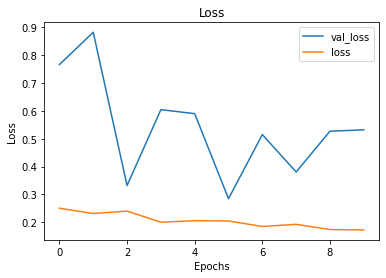

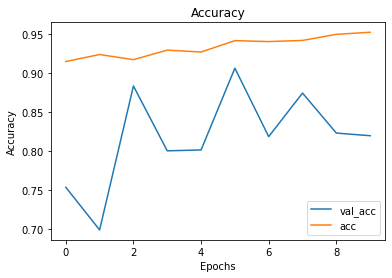

              precision    recall  f1-score   support

      normal       0.90      0.87      0.88       361
   pneumonia       0.91      0.93      0.92       517

    accuracy                           0.91       878
   macro avg       0.91      0.90      0.90       878
weighted avg       0.91      0.91      0.91       878



In [142]:
model = keras.models.load_model('models/model_13')
model = train_model(name='model_14',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=10)

<u>Notes:</u> Again, this is the best model yet with 90.66% validation accuracy.  The model performance still does bounce around wildly as we train epoch by epoch.  Lets increase the batch size to 30 and retrain the same network architecture for 20 epochs.

**$M_{15}$ - increase batch_size to 30, train for 20 epochs**

In [15]:
# get all the data in the directory split/test, and reshape them
size = (128,128)
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=30,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
tuning_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=30,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=30,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/20
137/137 [==============================] - 64s 461ms/step - loss: 0.6314 - acc: 0.8059 - val_loss: 0.8011 - val_acc: 0.5888
Epoch 2/20
137/137 [==============================] - 62s 456ms/step - loss: 0.5390 - acc: 0.8090 - val_loss: 1.0865 - val_acc: 0.5888
Epoch 3/20
137/137 [==============================] - 64s 462ms/step - loss: 0.4976 - acc: 0.8090 - val_loss: 0.7742 - val_acc: 0.5888
Epoch 4/20
137/137 [==============================] - 72s 524ms/step - loss: 0.4586 - acc: 0.8090 - val_loss: 0.5906 - val_acc: 0.5888
Epoch 5/20
137/137 [==============================] - 66s 477ms/step - loss: 0.3627 - acc: 0.8361 - val_loss: 0.4605 - val_acc: 0.8246
Epoch 6/20
137/137 [==============================] - 65s 472ms/step - loss: 0.3917 - acc: 0.8454 - val_loss: 0.6192 - val_acc: 0.7563
Epoch 7/20
137/137 [==============================] - 68s 498ms/step - loss: 0.3502 - acc: 0.8593 - val_loss: 0.7987 - val_acc: 0.6959
Epoch 8/20
137/137 [==============================] - 7

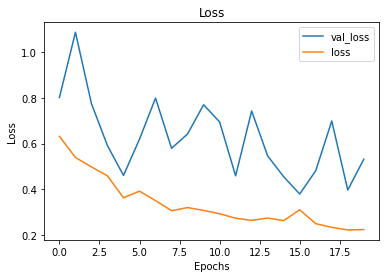

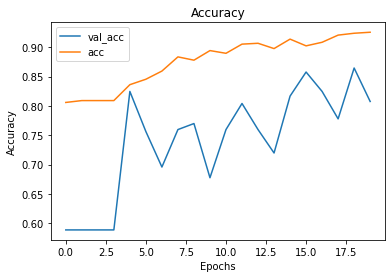

              precision    recall  f1-score   support

      normal       0.91      0.75      0.82       361
   pneumonia       0.84      0.95      0.89       517

    accuracy                           0.86       878
   macro avg       0.87      0.85      0.86       878
weighted avg       0.87      0.86      0.86       878



In [149]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.0001)))

model = train_model(name='model_15',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=20)


<u>Notes:</u> The model did not stablize at all and performed poorly. Lets revert to batch_size=20 and decrease the learning rate to 0.0001.

**$M_{16}$ - decrease learning rate to 0.0001**

In [17]:
# get all the data in the directory split/test, and reshape them
size = (128,128)
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
tuning_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/20
205/205 [==============================] - 104s 507ms/step - loss: 0.6029 - acc: 0.8090 - val_loss: 0.9547 - val_acc: 0.5888
Epoch 2/20
205/205 [==============================] - 83s 405ms/step - loss: 0.5549 - acc: 0.8090 - val_loss: 1.4994 - val_acc: 0.5888
Epoch 3/20
205/205 [==============================] - 69s 337ms/step - loss: 0.5754 - acc: 0.8090 - val_loss: 0.7614 - val_acc: 0.5888
Epoch 4/20
205/205 [==============================] - 82s 400ms/step - loss: 0.4865 - acc: 0.8168 - val_loss: 0.5057 - val_acc: 0.8132
Epoch 5/20
205/205 [==============================] - 78s 381ms/step - loss: 0.3974 - acc: 0.8432 - val_loss: 0.4854 - val_acc: 0.8098
Epoch 6/20
205/205 [==============================] - 81s 397ms/step - loss: 0.3695 - acc: 0.8524 - val_loss: 0.4857 - val_acc: 0.8018
Epoch 7/20
205/205 [==============================] - 96s 462ms/step - loss: 0.3555 - acc: 0.8610 - val_loss: 0.4914 - val_acc: 0.8155
Epoch 8/20
205/205 [==============================] - 

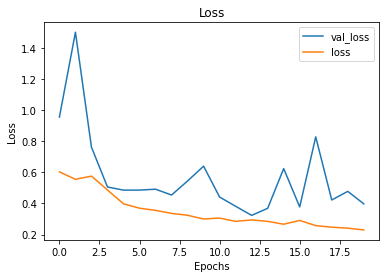

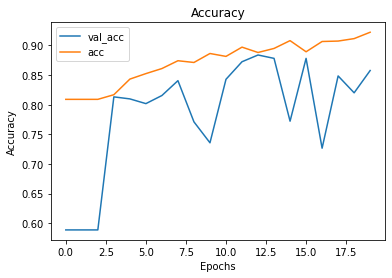

              precision    recall  f1-score   support

      normal       0.83      0.91      0.87       361
   pneumonia       0.93      0.87      0.90       517

    accuracy                           0.88       878
   macro avg       0.88      0.89      0.88       878
weighted avg       0.89      0.88      0.88       878



In [151]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.0001)))

model = train_model(name='model_16',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=20)


In [19]:
results

,precision,recall,f1,accuracy
model_0,0.85,0.93,0.89,0.866743
model_1,0.82,0.97,0.89,0.855353
model_2,0.59,1,0.74,0.588838
model_3,0.79,0.97,0.88,0.83713
model_4,0.82,0.94,0.88,0.843964
model_5,0.83,0.97,0.9,0.866743
model_6,0.83,0.95,0.89,0.857631
model_7,0.77,0.98,0.86,0.810934
model_8,0.84,0.96,0.9,0.870159
model_9,0.76,0.9,0.82,0.77221


<u>Notes:</u> The model performed fairly well but did not reach the performance of the $M_{14}$. The loss is not fluctuating as much either. Next lets try the same technique used to train $M_{14}$ by training $M_{13}$ for additional epochs but I'll decrease the learning rate.

**$M_{17}$ - decrease learning rate to 0.0001**

Epoch 1/20
205/205 [==============================] - 68s 331ms/step - loss: 0.3810 - acc: 0.8993 - val_loss: 0.4511 - val_acc: 0.8292
Epoch 2/20
205/205 [==============================] - 95s 463ms/step - loss: 0.2690 - acc: 0.9037 - val_loss: 0.5649 - val_acc: 0.8075
Epoch 3/20
205/205 [==============================] - 89s 436ms/step - loss: 0.2426 - acc: 0.9200 - val_loss: 0.8626 - val_acc: 0.6253
Epoch 4/20
205/205 [==============================] - 91s 442ms/step - loss: 0.3163 - acc: 0.9029 - val_loss: 1.0098 - val_acc: 0.6936
Epoch 5/20
205/205 [==============================] - 91s 445ms/step - loss: 0.2622 - acc: 0.9134 - val_loss: 0.4246 - val_acc: 0.8610
Epoch 6/20
205/205 [==============================] - 68s 333ms/step - loss: 0.2313 - acc: 0.9273 - val_loss: 0.4323 - val_acc: 0.8349
Epoch 7/20
205/205 [==============================] - 70s 342ms/step - loss: 0.3236 - acc: 0.9078 - val_loss: 0.3435 - val_acc: 0.8781
Epoch 8/20
205/205 [==============================] - 8

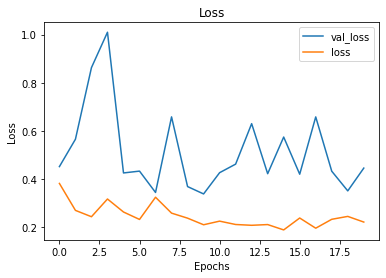

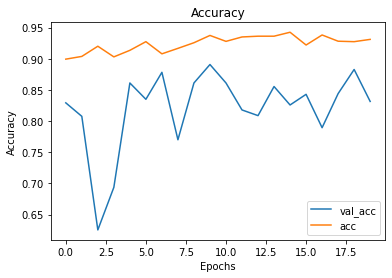

              precision    recall  f1-score   support

      normal       0.91      0.81      0.86       361
   pneumonia       0.88      0.95      0.91       517

    accuracy                           0.89       878
   macro avg       0.90      0.88      0.88       878
weighted avg       0.89      0.89      0.89       878



In [152]:
model = keras.models.load_model('models/model_13')
model = train_model(name='model_17',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=20)

<u>Notes:</u> The model accuracy did not improve on $M_{14}$ nor did it really stabilize.  Let's try some more preprocessing and see if we can enhance the images to bring out the patterns that show pneumonia.

**Histogram Equalization** - Here we'll make the dark parts of the images darker and the brighter parts a bit brighter using histogram equalization. This should illuminate the patterns that show pneumonia a little more, and therefore may be easier to recognize. The downside is that random noise will also be enhanced. As a results, we may have to tweak the model architecture and increase the regularization so as not to follow the random noise.

Original Xray Image:


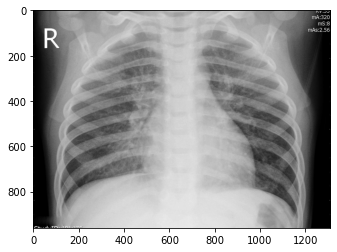

In [10]:
image = PIL.Image.open("chest_xray/train/PNEUMONIA/{}".format(train_pneum[0]))
print('Original Xray Image:')
plt.imshow(image, cmap='gray');

Enhanced Xray Image:


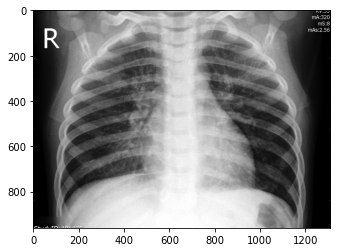

In [11]:
src = cv.imread("chest_xray/train/PNEUMONIA/{}".format(train_pneum[0]))
src = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
equ = cv.equalizeHist(src, cv.COLOR_BGR2GRAY)
image = PIL.Image.fromarray(equ)
print('Enhanced Xray Image:')
plt.imshow(image, cmap='gray');

Above you can see the difference histogram equalization makes.  In particular, the darkness inbetween the rib cage looks much darker in the second photo and all the bones and organs look a little brighter. Now, let's use histogram equalization to process all of the training, tuning, and validation images into a new folder called "enhanced".

In [33]:
# Create list of paths to each folder of data
paths = ['chest_xray/train/normal', 'chest_xray/train/pneumonia', 'chest_xray/test/normal', 
         'chest_xray/test/pneumonia', 'chest_xray/val/normal', 'chest_xray/val/pneumonia']
# For each folder
for path in paths:
    
    # Create a corresponding folder for the enhanced images
    enhanced = 'enhanced{}'.format(path[10:])
    os.makedirs(enhanced)
    
    # Get the file names for each image in the current path
    data = [file for file in os.listdir(path=path) if file.endswith('jpeg')]
    
    # For each image in the current folder, enhance it and add it to the corresponding enhanced folder
    for xray in data:
        src = cv.imread('{}/{}'.format(path, xray))
        src = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
        equ = cv.equalizeHist(src, cv.COLOR_BGR2GRAY)
        im = PIL.Image.fromarray(equ)
        im.save(enhanced+'/'+xray)   
        

In [48]:
# Create paths to new enhanced data folders
enhanced_train = 'enhanced/train'
enhanced_test = 'enhanced/test'
enhanced_val = 'enhanced/val'

$M_{17}$ - Run simple model on the enhanced data to get a baseline

In [49]:
# get all the data in the directory split/test, and reshape them
size = (128,128)
train_gen_en = ImageDataGenerator(rescale=1./255,
                               rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]).flow_from_directory(
        enhanced_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
tuning_gen_en = ImageDataGenerator(rescale=1./255).flow_from_directory(
        enhanced_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
en_val_gen_en = ImageDataGenerator(rescale=1./255).flow_from_directory(
        enhanced_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/10
205/205 [==============================] - 75s 366ms/step - loss: 0.8720 - acc: 0.7837 - val_loss: 0.6633 - val_acc: 0.5888
Epoch 2/10
205/205 [==============================] - 63s 305ms/step - loss: 0.4287 - acc: 0.8049 - val_loss: 0.5560 - val_acc: 0.6333
Epoch 3/10
205/205 [==============================] - 69s 336ms/step - loss: 0.3615 - acc: 0.8320 - val_loss: 0.5804 - val_acc: 0.7130
Epoch 4/10
205/205 [==============================] - 60s 293ms/step - loss: 0.2946 - acc: 0.8649 - val_loss: 0.5264 - val_acc: 0.7813
Epoch 5/10
205/205 [==============================] - 58s 284ms/step - loss: 0.2968 - acc: 0.8717 - val_loss: 0.3910 - val_acc: 0.8440
Epoch 6/10
205/205 [==============================] - 60s 291ms/step - loss: 0.2663 - acc: 0.8844 - val_loss: 0.4534 - val_acc: 0.8360
Epoch 7/10
205/205 [==============================] - 67s 327ms/step - loss: 0.2279 - acc: 0.9078 - val_loss: 0.4742 - val_acc: 0.8280
Epoch 8/10
205/205 [==============================] - 6

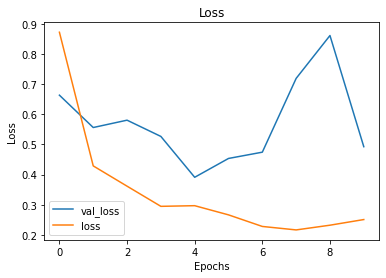

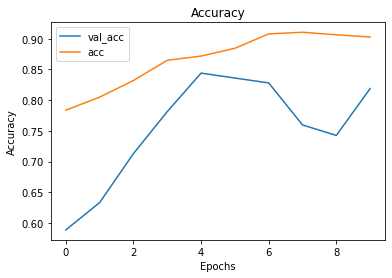

              precision    recall  f1-score   support

      normal       0.83      0.78      0.81       361
   pneumonia       0.85      0.89      0.87       517

    accuracy                           0.84       878
   macro avg       0.84      0.83      0.84       878
weighted avg       0.84      0.84      0.84       878



In [177]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_17',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen_en, 
                    tuning_gen=tuning_gen_en, 
                    metric='acc', 
                    epochs=10)


<u>Notes:</u> The model performed fairly well but starts to overfit around the 5th epoch.  Lets add some regularization

**$M_{18}$ - add l2 regularization**

Epoch 1/10
205/205 [==============================] - 77s 371ms/step - loss: 0.6949 - acc: 0.8041 - val_loss: 0.8080 - val_acc: 0.5888
Epoch 2/10
205/205 [==============================] - 63s 309ms/step - loss: 0.5289 - acc: 0.8090 - val_loss: 0.6678 - val_acc: 0.5888
Epoch 3/10
205/205 [==============================] - 59s 289ms/step - loss: 0.4221 - acc: 0.8090 - val_loss: 0.5686 - val_acc: 0.5888
Epoch 4/10
205/205 [==============================] - 62s 303ms/step - loss: 0.3617 - acc: 0.8090 - val_loss: 0.5879 - val_acc: 0.5888
Epoch 5/10
205/205 [==============================] - 71s 344ms/step - loss: 0.3499 - acc: 0.8090 - val_loss: 0.5328 - val_acc: 0.5888
Epoch 6/10
205/205 [==============================] - 63s 308ms/step - loss: 0.3311 - acc: 0.8063 - val_loss: 0.5345 - val_acc: 0.7677
Epoch 7/10
205/205 [==============================] - 59s 285ms/step - loss: 0.3123 - acc: 0.8734 - val_loss: 0.5308 - val_acc: 0.8235
Epoch 8/10
205/205 [==============================] - 7

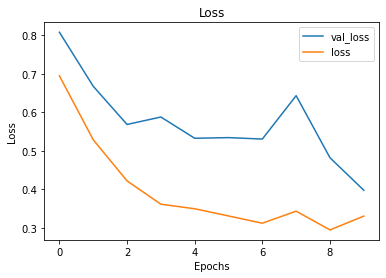

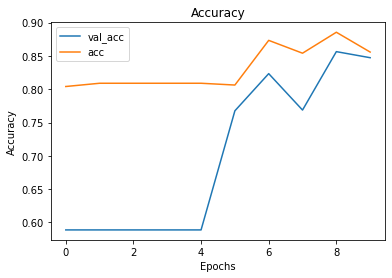

              precision    recall  f1-score   support

      normal       0.90      0.73      0.81       361
   pneumonia       0.83      0.95      0.89       517

    accuracy                           0.86       878
   macro avg       0.87      0.84      0.85       878
weighted avg       0.86      0.86      0.85       878



In [178]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.0001)))

model = train_model(name='model_18',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen_en, 
                    tuning_gen=tuning_gen_en, 
                    metric='acc', 
                    epochs=10)


<u>Notes:</u> The model performed fairly well and was on a path for improvement.  We'll continue training this model for a bit longer

**$M_{19}$ - continue training for more epochs**

Epoch 1/20
205/205 [==============================] - 63s 301ms/step - loss: 0.3420 - acc: 0.8649 - val_loss: 0.4091 - val_acc: 0.8622
Epoch 2/20
205/205 [==============================] - 66s 323ms/step - loss: 0.2659 - acc: 0.8983 - val_loss: 0.6899 - val_acc: 0.7642
Epoch 3/20
205/205 [==============================] - 67s 325ms/step - loss: 0.2697 - acc: 0.9015 - val_loss: 0.4802 - val_acc: 0.8292
Epoch 4/20
205/205 [==============================] - 60s 295ms/step - loss: 0.2764 - acc: 0.8985 - val_loss: 0.4243 - val_acc: 0.8599
Epoch 5/20
205/205 [==============================] - 61s 298ms/step - loss: 0.2547 - acc: 0.9046 - val_loss: 0.6758 - val_acc: 0.6948
Epoch 6/20
205/205 [==============================] - 69s 334ms/step - loss: 0.2457 - acc: 0.9102 - val_loss: 0.3348 - val_acc: 0.8781
Epoch 7/20
205/205 [==============================] - 63s 305ms/step - loss: 0.2497 - acc: 0.9088 - val_loss: 0.4519 - val_acc: 0.8394
Epoch 8/20
205/205 [==============================] - 5

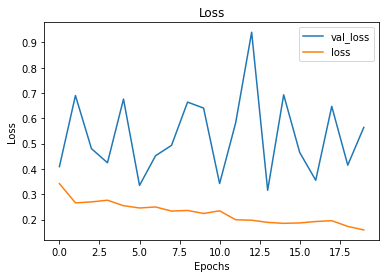

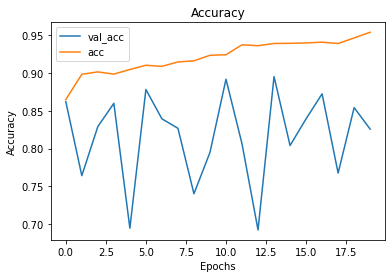

              precision    recall  f1-score   support

      normal       0.91      0.83      0.87       361
   pneumonia       0.89      0.94      0.91       517

    accuracy                           0.90       878
   macro avg       0.90      0.88      0.89       878
weighted avg       0.90      0.90      0.89       878



In [179]:
model = keras.models.load_model('models/model_18')
model = train_model(name='model_19',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen_en, 
                    tuning_gen=tuning_gen_en, 
                    metric='acc', 
                    epochs=20)

<u>Notes:</u> The model performed fairly well but still not as well as our best model. Accuracy is fluctuating as in our other models.  Lets repear the architecture of the best model and repeat on the enhanced data.  We'll run this for 50 epochs.

**$M_{20}$ - repeat $M_{13}$ architecture, train for 50 epochs**

Epoch 1/50
205/205 [==============================] - 74s 361ms/step - loss: 0.8066 - acc: 0.7851 - val_loss: 0.7881 - val_acc: 0.5888
Epoch 2/50
205/205 [==============================] - 71s 348ms/step - loss: 0.5436 - acc: 0.8090 - val_loss: 0.8744 - val_acc: 0.5888
Epoch 3/50
205/205 [==============================] - 87s 425ms/step - loss: 0.4277 - acc: 0.8083 - val_loss: 0.6179 - val_acc: 0.5888
Epoch 4/50
205/205 [==============================] - 91s 442ms/step - loss: 0.3868 - acc: 0.8090 - val_loss: 0.5501 - val_acc: 0.5888
Epoch 5/50
205/205 [==============================] - 93s 453ms/step - loss: 0.3568 - acc: 0.8271 - val_loss: 0.5362 - val_acc: 0.8405
Epoch 6/50
205/205 [==============================] - 107s 521ms/step - loss: 0.3211 - acc: 0.8839 - val_loss: 0.4613 - val_acc: 0.8622
Epoch 7/50
205/205 [==============================] - 97s 472ms/step - loss: 0.3371 - acc: 0.8661 - val_loss: 0.5963 - val_acc: 0.7950
Epoch 8/50
205/205 [==============================] - 

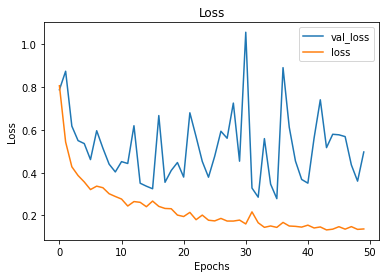

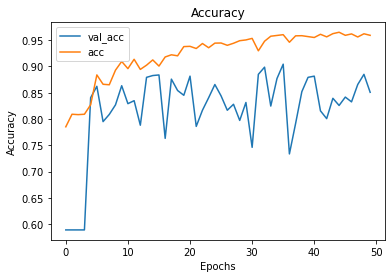

              precision    recall  f1-score   support

      normal       0.93      0.83      0.88       361
   pneumonia       0.89      0.95      0.92       517

    accuracy                           0.90       878
   macro avg       0.91      0.89      0.90       878
weighted avg       0.91      0.90      0.90       878



In [180]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.0001)))

model = train_model(name='model_20',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen_en, 
                    tuning_gen=tuning_gen_en, 
                    metric='acc', 
                    epochs=50)


<u>Notes:</u> The model performed well but not quite better than our best model.  Let's try to stablize the training by increasing the regularization.  Well also increase the learning rate so we don't get too stuck in local minimums and train for 50 epochs.

**$M_{21}$ - repeat $M_{13}$ architecture, train for 50 epochs, **

Epoch 1/50
205/205 [==============================] - 64s 310ms/step - loss: 1.1177 - acc: 0.7988 - val_loss: 1.0330 - val_acc: 0.5888
Epoch 2/50
205/205 [==============================] - 66s 323ms/step - loss: 0.7128 - acc: 0.8090 - val_loss: 0.8243 - val_acc: 0.5888
Epoch 3/50
205/205 [==============================] - 70s 340ms/step - loss: 0.8539 - acc: 0.8090 - val_loss: 0.8032 - val_acc: 0.5888
Epoch 4/50
205/205 [==============================] - 63s 307ms/step - loss: 0.6401 - acc: 0.8090 - val_loss: 0.8960 - val_acc: 0.5888
Epoch 5/50
205/205 [==============================] - 58s 284ms/step - loss: 0.6038 - acc: 0.8090 - val_loss: 0.8255 - val_acc: 0.5888
Epoch 6/50
205/205 [==============================] - 60s 294ms/step - loss: 0.5882 - acc: 0.8090 - val_loss: 0.8331 - val_acc: 0.5888
Epoch 7/50
205/205 [==============================] - 69s 335ms/step - loss: 0.5585 - acc: 0.8090 - val_loss: 0.8860 - val_acc: 0.5888
Epoch 8/50
205/205 [==============================] - 6

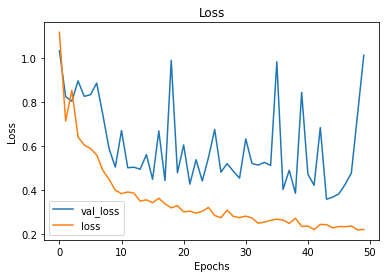

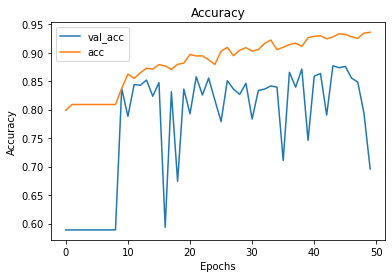

              precision    recall  f1-score   support

      normal       0.84      0.86      0.85       361
   pneumonia       0.90      0.89      0.89       517

    accuracy                           0.88       878
   macro avg       0.87      0.88      0.87       878
weighted avg       0.88      0.88      0.88       878



In [182]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.001)))

model = train_model(name='model_21',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen_en, 
                    tuning_gen=tuning_gen_en, 
                    metric='acc', 
                    epochs=50)


<u>Notes:</u> The model performed well but validation accuracy and val_loss are fluctuating a lot.  The model does appear to be getting better with time and has not yet plateaued. Lets reload and train it for longer.

**$M_{22}$ - continue training $M_{21}$ for 20 more epochs**

Epoch 1/20
205/205 [==============================] - 67s 326ms/step - loss: 0.2364 - acc: 0.9246 - val_loss: 0.5479 - val_acc: 0.8371
Epoch 2/20
205/205 [==============================] - 71s 347ms/step - loss: 0.2287 - acc: 0.9327 - val_loss: 0.5544 - val_acc: 0.8326
Epoch 3/20
205/205 [==============================] - 62s 303ms/step - loss: 0.2303 - acc: 0.9327 - val_loss: 0.5544 - val_acc: 0.8178
Epoch 4/20
205/205 [==============================] - 59s 290ms/step - loss: 0.2200 - acc: 0.9332 - val_loss: 0.5993 - val_acc: 0.7893
Epoch 5/20
205/205 [==============================] - 66s 320ms/step - loss: 0.2165 - acc: 0.9344 - val_loss: 0.4177 - val_acc: 0.8656
Epoch 6/20
205/205 [==============================] - 70s 342ms/step - loss: 0.2293 - acc: 0.9307 - val_loss: 0.5418 - val_acc: 0.8349
Epoch 7/20
205/205 [==============================] - 60s 292ms/step - loss: 0.2070 - acc: 0.9368 - val_loss: 0.5638 - val_acc: 0.8280
Epoch 8/20
205/205 [==============================] - 5

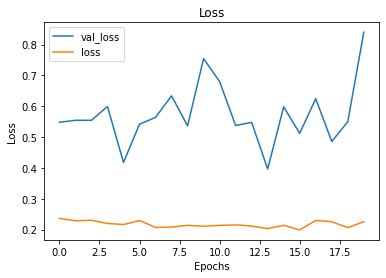

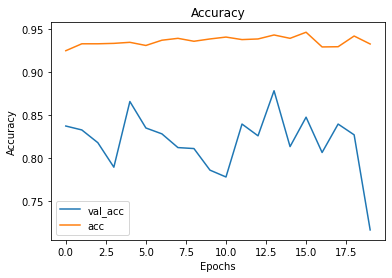

              precision    recall  f1-score   support

      normal       0.89      0.81      0.84       361
   pneumonia       0.87      0.93      0.90       517

    accuracy                           0.88       878
   macro avg       0.88      0.87      0.87       878
weighted avg       0.88      0.88      0.88       878



In [183]:
model = keras.models.load_model('models/model_21')
model = train_model(name='model_22',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen_en, 
                    tuning_gen=tuning_gen_en, 
                    metric='acc', 
                    epochs=20)

<u>Notes:</u> The model performance did not increase. Let's try to stabelize the accuracy by removing some complexity

**$M_{23}$ - remove the dense 254 layer and retrain**

Epoch 1/50
205/205 [==============================] - 56s 272ms/step - loss: 0.8220 - acc: 0.7990 - val_loss: 1.0760 - val_acc: 0.5888
Epoch 2/50
205/205 [==============================] - 73s 355ms/step - loss: 0.5728 - acc: 0.8090 - val_loss: 0.7983 - val_acc: 0.5888
Epoch 3/50
205/205 [==============================] - 70s 343ms/step - loss: 0.5343 - acc: 0.8090 - val_loss: 0.7719 - val_acc: 0.5888
Epoch 4/50
205/205 [==============================] - 61s 297ms/step - loss: 0.5177 - acc: 0.8090 - val_loss: 0.6161 - val_acc: 0.5888
Epoch 5/50
205/205 [==============================] - 62s 304ms/step - loss: 0.5009 - acc: 0.8090 - val_loss: 0.5833 - val_acc: 0.5888
Epoch 6/50
205/205 [==============================] - 70s 340ms/step - loss: 0.4286 - acc: 0.8090 - val_loss: 0.6095 - val_acc: 0.5888
Epoch 7/50
205/205 [==============================] - 61s 296ms/step - loss: 0.4055 - acc: 0.8090 - val_loss: 0.5930 - val_acc: 0.5888
Epoch 8/50
205/205 [==============================] - 6

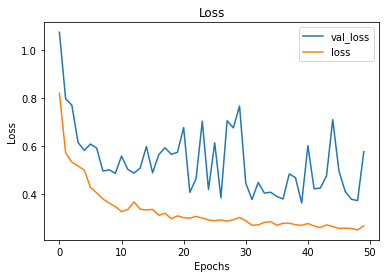

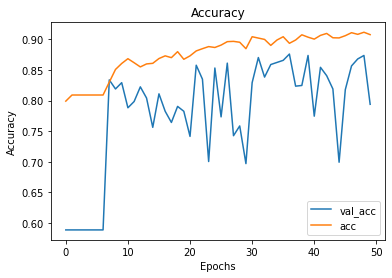

              precision    recall  f1-score   support

      normal       0.89      0.80      0.84       361
   pneumonia       0.87      0.93      0.90       517

    accuracy                           0.88       878
   macro avg       0.88      0.86      0.87       878
weighted avg       0.88      0.88      0.87       878



In [184]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.001)))

model = train_model(name='model_23',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen_en, 
                    tuning_gen=tuning_gen_en, 
                    metric='acc', 
                    epochs=50)


<u>Notes:</u> The model performance did not increase. Let's simplify and remove all but the first conv2d layer.

**$M_{24}$ - remove the dense conv2d layers except the first, retrain**

Epoch 1/50
205/205 [==============================] - 96s 466ms/step - loss: 1.7867 - acc: 0.7812 - val_loss: 1.5086 - val_acc: 0.5888
Epoch 2/50
205/205 [==============================] - 90s 438ms/step - loss: 0.6678 - acc: 0.8090 - val_loss: 0.9431 - val_acc: 0.5888
Epoch 3/50
205/205 [==============================] - 81s 394ms/step - loss: 0.5794 - acc: 0.8090 - val_loss: 0.6821 - val_acc: 0.5888
Epoch 4/50
205/205 [==============================] - 81s 397ms/step - loss: 0.5631 - acc: 0.8090 - val_loss: 0.7516 - val_acc: 0.5888
Epoch 5/50
205/205 [==============================] - 77s 376ms/step - loss: 0.5155 - acc: 0.8090 - val_loss: 0.6386 - val_acc: 0.5888
Epoch 6/50
205/205 [==============================] - 69s 337ms/step - loss: 0.5057 - acc: 0.8090 - val_loss: 0.8036 - val_acc: 0.5888
Epoch 7/50
205/205 [==============================] - 69s 337ms/step - loss: 0.4973 - acc: 0.8090 - val_loss: 0.6028 - val_acc: 0.5888
Epoch 8/50
205/205 [==============================] - 7

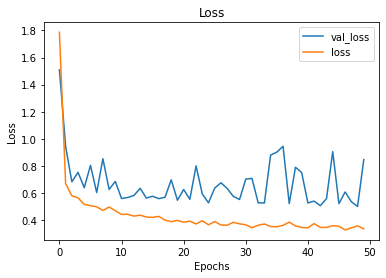

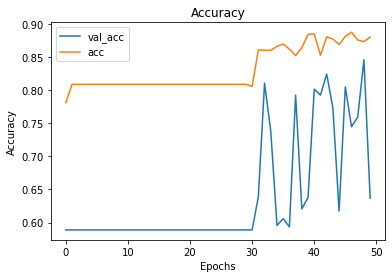

              precision    recall  f1-score   support

      normal       0.88      0.72      0.79       361
   pneumonia       0.83      0.93      0.88       517

    accuracy                           0.85       878
   macro avg       0.86      0.83      0.84       878
weighted avg       0.85      0.85      0.84       878



In [186]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.001)))

model = train_model(name='model_24',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen_en, 
                    tuning_gen=tuning_gen_en, 
                    metric='acc', 
                    epochs=50)


<u>Notes:</u> Still not more stable, lets add the dense layer 254 back in 

**$M_{25}$ - Add the dense layer 254 back in **

Epoch 1/50
205/205 [==============================] - 109s 519ms/step - loss: 1.5636 - acc: 0.7417 - val_loss: 1.0128 - val_acc: 0.5888
Epoch 2/50
205/205 [==============================] - 88s 429ms/step - loss: 0.7969 - acc: 0.8049 - val_loss: 1.0023 - val_acc: 0.5888
Epoch 3/50
205/205 [==============================] - 75s 368ms/step - loss: 0.6802 - acc: 0.8090 - val_loss: 0.9455 - val_acc: 0.5888
Epoch 4/50
205/205 [==============================] - 100s 479ms/step - loss: 0.6151 - acc: 0.8090 - val_loss: 0.7366 - val_acc: 0.5888
Epoch 5/50
205/205 [==============================] - 120s 577ms/step - loss: 0.5791 - acc: 0.8090 - val_loss: 0.6736 - val_acc: 0.5888
Epoch 6/50
205/205 [==============================] - 66s 321ms/step - loss: 0.5352 - acc: 0.8090 - val_loss: 0.7028 - val_acc: 0.5888
Epoch 7/50
205/205 [==============================] - 105s 513ms/step - loss: 0.5245 - acc: 0.8090 - val_loss: 0.7209 - val_acc: 0.5888
Epoch 8/50
205/205 [==============================]

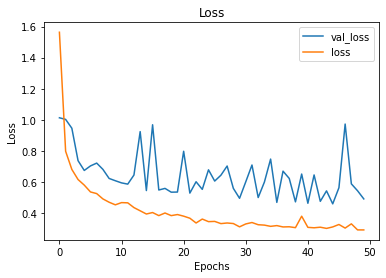

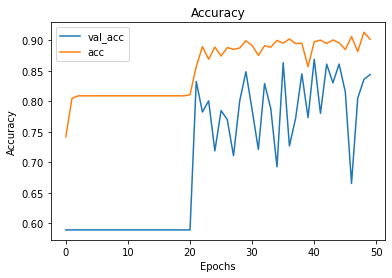

              precision    recall  f1-score   support

      normal       0.90      0.77      0.83       361
   pneumonia       0.85      0.94      0.89       517

    accuracy                           0.87       878
   macro avg       0.88      0.85      0.86       878
weighted avg       0.87      0.87      0.87       878



In [187]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.001)))

model = train_model(name='model_25',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen_en, 
                    tuning_gen=tuning_gen_en, 
                    metric='acc', 
                    epochs=50)


<u>Notes:</u> The model performance did not increase. let's try changing the resolution to (256, 256)

**$M_{26}$ - change resolution to (256,256)**

In [24]:
# get all the data in the directory split/test, and reshape them
size = (256,256)
train_gen_en = ImageDataGenerator(rescale=1./255,
                               rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]).flow_from_directory(
        enhanced_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
tuning_gen_en = ImageDataGenerator(rescale=1./255).flow_from_directory(
        enhanced_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
val_gen_en = ImageDataGenerator(rescale=1./255).flow_from_directory(
        enhanced_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/50
205/205 [==============================] - 204s 991ms/step - loss: 1.4938 - acc: 0.7683 - val_loss: 1.2295 - val_acc: 0.5888
Epoch 2/50
205/205 [==============================] - 201s 981ms/step - loss: 0.6572 - acc: 0.8090 - val_loss: 0.9899 - val_acc: 0.5888
Epoch 3/50
205/205 [==============================] - 193s 942ms/step - loss: 0.5743 - acc: 0.8093 - val_loss: 0.8813 - val_acc: 0.5888
Epoch 4/50
205/205 [==============================] - 192s 936ms/step - loss: 0.5269 - acc: 0.8090 - val_loss: 0.8324 - val_acc: 0.5888
Epoch 5/50
205/205 [==============================] - 194s 947ms/step - loss: 0.5150 - acc: 0.8090 - val_loss: 0.8507 - val_acc: 0.5888
Epoch 6/50
205/205 [==============================] - 198s 965ms/step - loss: 0.5078 - acc: 0.8090 - val_loss: 0.6254 - val_acc: 0.5888
Epoch 7/50
205/205 [==============================] - 199s 971ms/step - loss: 0.4862 - acc: 0.8090 - val_loss: 0.7336 - val_acc: 0.5888
Epoch 8/50
205/205 [============================

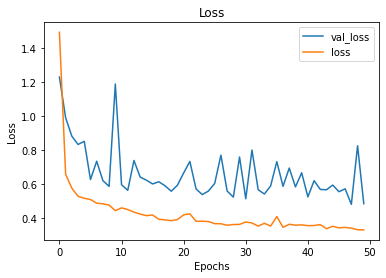

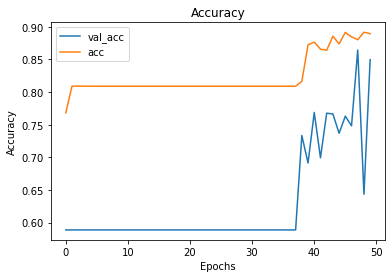

              precision    recall  f1-score   support

      normal       0.89      0.76      0.82       361
   pneumonia       0.85      0.94      0.89       517

    accuracy                           0.86       878
   macro avg       0.87      0.85      0.86       878
weighted avg       0.87      0.86      0.86       878



In [189]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256,256, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.001)))

model = train_model(name='model_26',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen_en, 
                    tuning_gen=tuning_gen_en, 
                    metric='acc', 
                    epochs=50)


<u>Notes:</u> The model performance did not increase.

**$M_{27}$ - add in the dense layer 256**

Epoch 1/50
205/205 [==============================] - 200s 969ms/step - loss: 2.6719 - acc: 0.7215 - val_loss: 0.9194 - val_acc: 0.5888
Epoch 2/50
205/205 [==============================] - 194s 946ms/step - loss: 0.8103 - acc: 0.8015 - val_loss: 0.8829 - val_acc: 0.5888
Epoch 3/50
205/205 [==============================] - 191s 931ms/step - loss: 0.6888 - acc: 0.8088 - val_loss: 0.8603 - val_acc: 0.5888
Epoch 4/50
205/205 [==============================] - 196s 954ms/step - loss: 0.6244 - acc: 0.8090 - val_loss: 0.7292 - val_acc: 0.5888
Epoch 5/50
205/205 [==============================] - 197s 963ms/step - loss: 0.5991 - acc: 0.8090 - val_loss: 0.7496 - val_acc: 0.5888
Epoch 6/50
205/205 [==============================] - 196s 954ms/step - loss: 0.5632 - acc: 0.8090 - val_loss: 0.8862 - val_acc: 0.5888
Epoch 7/50
205/205 [==============================] - 186s 905ms/step - loss: 0.5470 - acc: 0.8090 - val_loss: 0.6605 - val_acc: 0.5888
Epoch 8/50
205/205 [============================

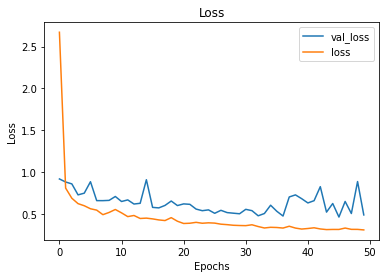

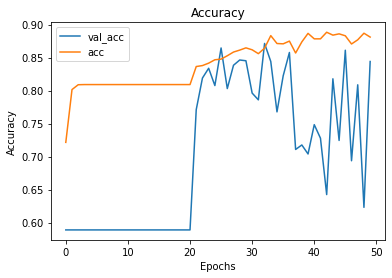

              precision    recall  f1-score   support

      normal       0.88      0.79      0.84       361
   pneumonia       0.86      0.93      0.89       517

    accuracy                           0.87       878
   macro avg       0.87      0.86      0.86       878
weighted avg       0.87      0.87      0.87       878



In [190]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256,256, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.001)))

model = train_model(name='model_27',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen_en, 
                    tuning_gen=tuning_gen_en, 
                    metric='acc', 
                    epochs=50)


<u>Notes:</u> The model performance did not increase and still fluctuates wildly.   Let's go back to the architecture of the best model $M_{14}$.  From here lets try to stabilize the model a little.  I'll start by increasing the learning rate, which in theory should not decrease the fluctuations in accuracy, but I would like to see how the model performs.

**$M_{27}$ - Decrease resolution, decrease learning rate**

In [13]:
# get all the data in the directory split/test, and reshape them
size = (128,128)
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
tuning_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/50
205/205 [==============================] - 63s 303ms/step - loss: 140813.2656 - acc: 0.7427 - val_loss: 61.7264 - val_acc: 0.5888
Epoch 2/50
205/205 [==============================] - 72s 349ms/step - loss: 67.1858 - acc: 0.8015 - val_loss: 57.8233 - val_acc: 0.5888
Epoch 3/50
205/205 [==============================] - 71s 348ms/step - loss: 56.7448 - acc: 0.8090 - val_loss: 63.2207 - val_acc: 0.5888
Epoch 4/50
205/205 [==============================] - 63s 309ms/step - loss: 53.1952 - acc: 0.8090 - val_loss: 51.3269 - val_acc: 0.5888
Epoch 5/50
205/205 [==============================] - 62s 302ms/step - loss: 52.1428 - acc: 0.8090 - val_loss: 50.5304 - val_acc: 0.5888
Epoch 6/50
205/205 [==============================] - 68s 331ms/step - loss: 50.5566 - acc: 0.8090 - val_loss: 52.9228 - val_acc: 0.5888
Epoch 7/50
205/205 [==============================] - 72s 350ms/step - loss: 50.8709 - acc: 0.8090 - val_loss: 49.3876 - val_acc: 0.5888
Epoch 8/50
205/205 [=================

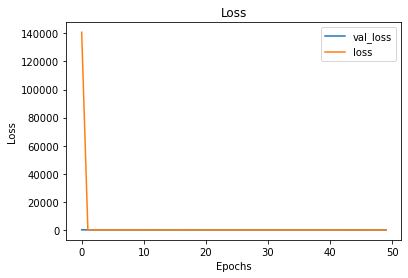

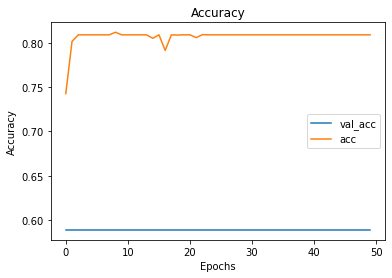

C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       361
   pneumonia       0.59      1.00      0.74       517

    accuracy                           0.59       878
   macro avg       0.29      0.50      0.37       878
weighted avg       0.35      0.59      0.44       878



In [48]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.001)))

model = train_model(name='model_28',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.1),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=50)


<u>Notes:</u> The model looks like it got stuck and did not train through due to the large learning rate.  Lets decrease that learning rate back to its original value. Then, we'll train the original model through for 50 straight epochs.

**$M_{29}$ - best model trained for 50 epochs**

Epoch 1/50
205/205 [==============================] - 67s 325ms/step - loss: 0.6730 - acc: 0.8090 - val_loss: 0.8816 - val_acc: 0.5888
Epoch 2/50
205/205 [==============================] - 73s 357ms/step - loss: 0.5339 - acc: 0.8090 - val_loss: 0.6961 - val_acc: 0.5888
Epoch 3/50
205/205 [==============================] - 72s 352ms/step - loss: 0.4482 - acc: 0.8180 - val_loss: 0.8010 - val_acc: 0.6139
Epoch 4/50
205/205 [==============================] - 70s 341ms/step - loss: 0.4073 - acc: 0.8337 - val_loss: 0.5611 - val_acc: 0.7574
Epoch 5/50
205/205 [==============================] - 70s 343ms/step - loss: 0.3480 - acc: 0.8744 - val_loss: 0.6710 - val_acc: 0.6868
Epoch 6/50
205/205 [==============================] - 73s 356ms/step - loss: 0.3030 - acc: 0.8820 - val_loss: 0.5743 - val_acc: 0.7893
Epoch 7/50
205/205 [==============================] - 73s 356ms/step - loss: 0.3162 - acc: 0.8859 - val_loss: 0.3493 - val_acc: 0.8793
Epoch 8/50
205/205 [==============================] - 6

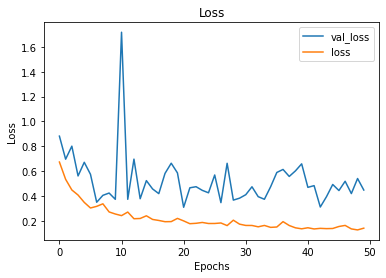

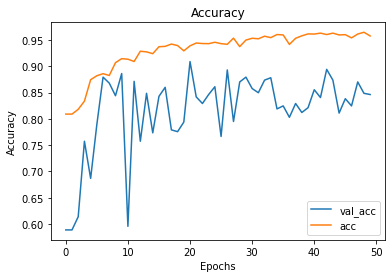

              precision    recall  f1-score   support

      normal       0.92      0.86      0.89       361
   pneumonia       0.90      0.95      0.92       517

    accuracy                           0.91       878
   macro avg       0.91      0.90      0.90       878
weighted avg       0.91      0.91      0.91       878



In [50]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.0001)))

model = train_model(name='model_29',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=50)


<u>Notes:</u> The model looks very similar to the original, but as shown the accuracy still is fluctuating a lot.  Let's try to minimize that by increasing the dropout rate to 0.5.

**$M_{30}$ - increase the dropout rate to 0.5 and learning_rate to 0.0001 and train for 30 epochs.**

Epoch 1/30
205/205 [==============================] - 57s 274ms/step - loss: 0.6126 - acc: 0.8044 - val_loss: 0.9506 - val_acc: 0.5888
Epoch 2/30
205/205 [==============================] - 70s 343ms/step - loss: 0.5680 - acc: 0.8090 - val_loss: 0.6985 - val_acc: 0.5888
Epoch 3/30
205/205 [==============================] - 71s 349ms/step - loss: 0.5266 - acc: 0.8088 - val_loss: 0.6388 - val_acc: 0.5888
Epoch 4/30
205/205 [==============================] - 66s 322ms/step - loss: 0.4511 - acc: 0.8095 - val_loss: 0.5415 - val_acc: 0.8303
Epoch 5/30
205/205 [==============================] - 64s 310ms/step - loss: 0.4010 - acc: 0.8307 - val_loss: 0.4542 - val_acc: 0.8371
Epoch 6/30
205/205 [==============================] - 73s 353ms/step - loss: 0.3833 - acc: 0.8500 - val_loss: 0.4749 - val_acc: 0.8132
Epoch 7/30
205/205 [==============================] - 66s 322ms/step - loss: 0.3621 - acc: 0.8532 - val_loss: 0.4226 - val_acc: 0.8827
Epoch 8/30
205/205 [==============================] - 6

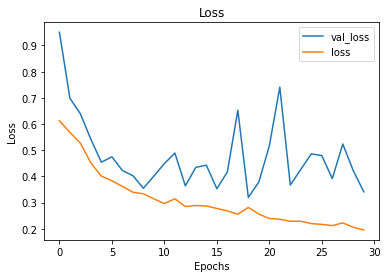

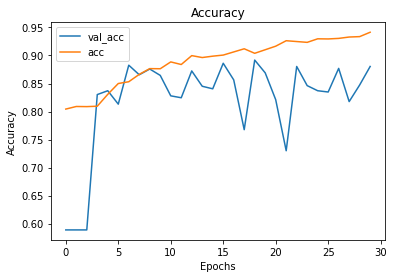

              precision    recall  f1-score   support

      normal       0.89      0.84      0.86       361
   pneumonia       0.89      0.93      0.91       517

    accuracy                           0.89       878
   macro avg       0.89      0.88      0.89       878
weighted avg       0.89      0.89      0.89       878



In [51]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.0001)))

model = train_model(name='model_30',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=30)


<u>Notes:</u> While still fluctuating, at least its range of fluctuation is smaller.  It seems like the learning rate may need to be smaller but when decreased, the model gets stuck at a local minimum and ceases to train further.  Let's train a model for 5 epochs at a higher learning rate then stop it.  Then we'll reload this architecture into a new model and train it with a smaller learning rate so as to hop over the first local minimum.

**$M_{31}$ - increase learning rate to 0.0005**

Epoch 1/5
205/205 [==============================] - 69s 331ms/step - loss: 0.6183 - acc: 0.7961 - val_loss: 0.7749 - val_acc: 0.5888
Epoch 2/5
205/205 [==============================] - 72s 352ms/step - loss: 0.5515 - acc: 0.8271 - val_loss: 0.6660 - val_acc: 0.6481
Epoch 3/5
205/205 [==============================] - 66s 322ms/step - loss: 0.3968 - acc: 0.8283 - val_loss: 0.4204 - val_acc: 0.8235
Epoch 4/5
205/205 [==============================] - 62s 304ms/step - loss: 0.3388 - acc: 0.8656 - val_loss: 0.3743 - val_acc: 0.8633
Epoch 5/5
205/205 [==============================] - 69s 336ms/step - loss: 0.3374 - acc: 0.8693 - val_loss: 0.8750 - val_acc: 0.6219
INFO:tensorflow:Assets written to: models/model_31\assets


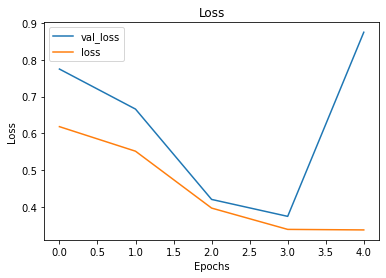

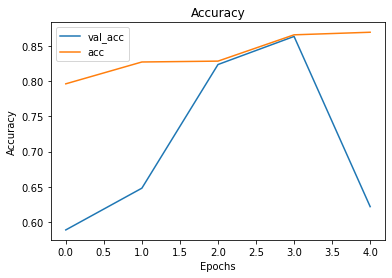

              precision    recall  f1-score   support

      normal       0.85      0.81      0.83       361
   pneumonia       0.87      0.90      0.89       517

    accuracy                           0.86       878
   macro avg       0.86      0.86      0.86       878
weighted avg       0.86      0.86      0.86       878



In [54]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.0001)))

model = train_model(name='model_31',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=5)


<u>Notes:</u> Model appears to be training passed the local minimum.  Reload the model and decrease the learning rate.

**$M_{32}$ - train previous model with decreased learning rate**

Epoch 1/50
205/205 [==============================] - 70s 338ms/step - loss: 0.3008 - acc: 0.8827 - val_loss: 0.4264 - val_acc: 0.8303
Epoch 2/50
205/205 [==============================] - 68s 330ms/step - loss: 0.2770 - acc: 0.8917 - val_loss: 0.4442 - val_acc: 0.8223
Epoch 3/50
205/205 [==============================] - 66s 322ms/step - loss: 0.2898 - acc: 0.8776 - val_loss: 0.4282 - val_acc: 0.8314
Epoch 4/50
205/205 [==============================] - 71s 349ms/step - loss: 0.2942 - acc: 0.8754 - val_loss: 0.4486 - val_acc: 0.8166
Epoch 5/50
205/205 [==============================] - 65s 318ms/step - loss: 0.2792 - acc: 0.8873 - val_loss: 0.4393 - val_acc: 0.8280
Epoch 6/50
205/205 [==============================] - 63s 305ms/step - loss: 0.2747 - acc: 0.8922 - val_loss: 0.4464 - val_acc: 0.8257
Epoch 7/50
205/205 [==============================] - 69s 337ms/step - loss: 0.2751 - acc: 0.8927 - val_loss: 0.4252 - val_acc: 0.8360
Epoch 8/50
205/205 [==============================] - 8

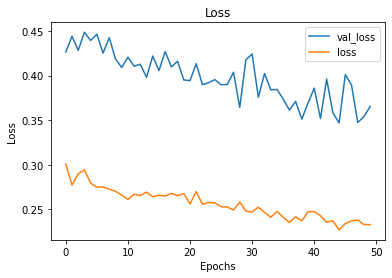

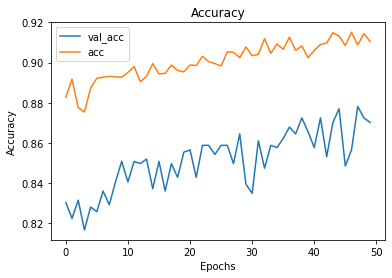

              precision    recall  f1-score   support

      normal       0.89      0.80      0.84       361
   pneumonia       0.87      0.93      0.90       517

    accuracy                           0.88       878
   macro avg       0.88      0.87      0.87       878
weighted avg       0.88      0.88      0.88       878



In [55]:
model = keras.models.load_model('models/model_31')
model = train_model(name='model_32',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=50)

<u>Notes:</u> The model appears to be training, just very slowly. Let's repeat this experiment from the beginning except we'll choose a learning rate that can escape the first local minimum but small enough to continue improving as well progress over a longer period of training 100 epochs.

**$M_{33}$ - train best architecture from instantiation for 100 epochs.**

In [10]:
# get all the data in the directory split/test, and reshape them
size = (128,128)
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
tuning_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/100
82/82 [==============================] - 57s 695ms/step - loss: 0.6795 - acc: 0.8010 - val_loss: 1.3536 - val_acc: 0.5888
Epoch 2/100
82/82 [==============================] - 100s 1s/step - loss: 0.5988 - acc: 0.8090 - val_loss: 0.8027 - val_acc: 0.5888
Epoch 3/100
82/82 [==============================] - 105s 1s/step - loss: 0.5780 - acc: 0.8090 - val_loss: 1.0335 - val_acc: 0.5888
Epoch 4/100
82/82 [==============================] - 97s 1s/step - loss: 0.5793 - acc: 0.8090 - val_loss: 0.9705 - val_acc: 0.5888
Epoch 5/100
82/82 [==============================] - 93s 1s/step - loss: 0.5740 - acc: 0.8090 - val_loss: 0.8618 - val_acc: 0.5888
Epoch 6/100
82/82 [==============================] - 111s 1s/step - loss: 0.5441 - acc: 0.8090 - val_loss: 0.6426 - val_acc: 0.5888
Epoch 7/100
82/82 [==============================] - 97s 1s/step - loss: 0.4802 - acc: 0.8083 - val_loss: 0.5853 - val_acc: 0.5888
Epoch 8/100
82/82 [==============================] - 97s 1s/step - loss: 0.43

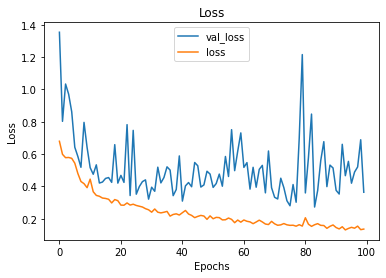

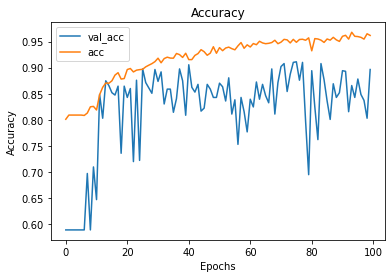

              precision    recall  f1-score   support

      normal       0.92      0.86      0.89       361
   pneumonia       0.91      0.95      0.93       517

    accuracy                           0.91       878
   macro avg       0.91      0.90      0.91       878
weighted avg       0.91      0.91      0.91       878



In [57]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(.0001)))

model = train_model(name='model_33',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=100)


In [31]:
model = keras.models.load_model('models/model_33')
add_results(model, 'model_33')

In [32]:
results

,precision,recall,f1,accuracy
model_0,0.85,0.93,0.89,0.866743
model_1,0.82,0.97,0.89,0.855353
model_2,0.59,1,0.74,0.588838
model_3,0.79,0.97,0.88,0.83713
model_4,0.82,0.94,0.88,0.843964
model_5,0.83,0.97,0.9,0.866743
model_6,0.83,0.95,0.89,0.857631
model_7,0.77,0.98,0.86,0.810934
model_8,0.84,0.96,0.9,0.870159
model_9,0.76,0.9,0.82,0.77221


<u>Notes:</u> The model  has our highest accuracy yet, but still seems to fluctuate a lot.  $M_{32}$ was our most consistent model and was improving even through the end of 50 epochs.  Let's repeat this model but let it run for 100 epochs.

**$M_{32}$ - continue training $M_{31}$for 100 epochs**

Epoch 1/100
205/205 [==============================] - 91s 439ms/step - loss: 0.2910 - acc: 0.8873 - val_loss: 0.4368 - val_acc: 0.8257
Epoch 2/100
205/205 [==============================] - 70s 344ms/step - loss: 0.2796 - acc: 0.8900 - val_loss: 0.4280 - val_acc: 0.8326
Epoch 3/100
205/205 [==============================] - 69s 338ms/step - loss: 0.2827 - acc: 0.8844 - val_loss: 0.4279 - val_acc: 0.8337
Epoch 4/100
205/205 [==============================] - 64s 315ms/step - loss: 0.2816 - acc: 0.8917 - val_loss: 0.4241 - val_acc: 0.8349
Epoch 5/100
205/205 [==============================] - 66s 321ms/step - loss: 0.2750 - acc: 0.8902 - val_loss: 0.4436 - val_acc: 0.8292
Epoch 6/100
205/205 [==============================] - 69s 338ms/step - loss: 0.2753 - acc: 0.8910 - val_loss: 0.4395 - val_acc: 0.8303
Epoch 7/100
205/205 [==============================] - 63s 308ms/step - loss: 0.2832 - acc: 0.8873 - val_loss: 0.4075 - val_acc: 0.8485
Epoch 8/100
205/205 [===========================

Epoch 61/100
205/205 [==============================] - 71s 349ms/step - loss: 0.2334 - acc: 0.9144 - val_loss: 0.3578 - val_acc: 0.8747
Epoch 62/100
205/205 [==============================] - 64s 311ms/step - loss: 0.2277 - acc: 0.9207 - val_loss: 0.3935 - val_acc: 0.8542
Epoch 63/100
205/205 [==============================] - 63s 307ms/step - loss: 0.2328 - acc: 0.9159 - val_loss: 0.3632 - val_acc: 0.8736
Epoch 64/100
205/205 [==============================] - 68s 330ms/step - loss: 0.2231 - acc: 0.9173 - val_loss: 0.3778 - val_acc: 0.8645
Epoch 65/100
205/205 [==============================] - 72s 351ms/step - loss: 0.2269 - acc: 0.9190 - val_loss: 0.3473 - val_acc: 0.8770
Epoch 66/100
205/205 [==============================] - 63s 308ms/step - loss: 0.2159 - acc: 0.9183 - val_loss: 0.3481 - val_acc: 0.8759
Epoch 67/100
205/205 [==============================] - 61s 300ms/step - loss: 0.2207 - acc: 0.9159 - val_loss: 0.3870 - val_acc: 0.8633
Epoch 68/100
205/205 [===================

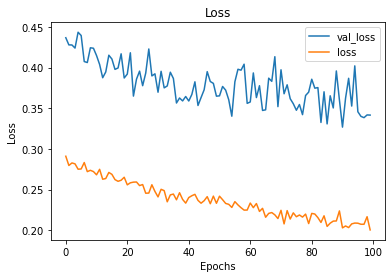

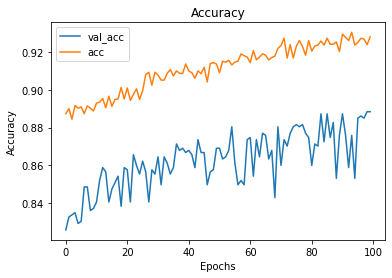

              precision    recall  f1-score   support

      normal       0.93      0.79      0.85       361
   pneumonia       0.87      0.96      0.91       517

    accuracy                           0.89       878
   macro avg       0.90      0.87      0.88       878
weighted avg       0.89      0.89      0.89       878



In [14]:
model = keras.models.load_model('models/model_31')
model = train_model(name='model_32',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                    train_gen=train_gen, 
                    tuning_gen=tuning_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u> The model is somewhat more stable, however the overall accuracy only improved marginally as trained over 50 more epochs than last time.

In [ ]:
results.to_csv('results')

Now that we have iterated on the model and improved it, let's pick a model and evaluate it.
## Evaluation
___
Below, lets subset the results dataframe to the top 10 models based on accuracy.

In [44]:
top_models = results.sort_values(by=['accuracy'], ascending=False).iloc[:10,:].index
results.sort_values(by=['accuracy'], ascending=False).iloc[:10,:]

,precision,recall,f1,accuracy
model_33,0.91,0.95,0.93,0.911162
model_29,0.90,0.95,0.92,0.908884
model_14,0.91,0.93,0.92,0.906606
model_20,0.89,0.95,0.92,0.904328
model_19,0.89,0.94,0.91,0.895216
model_13,0.90,0.92,0.91,0.894077
model_30,0.89,0.93,0.91,0.891800
model_32,0.87,0.96,0.91,0.888383
model_16,0.93,0.87,0.90,0.883827
model_22,0.87,0.93,0.90,0.878132


The top 10 models above are our most accurate models. While accuracy is an important metric in our evaluation, it's important to remember that in the case of classifying pneumonia it would be better to have more false negatives than false positives.  Below, we'll print out the classification report as well as the confusion matrices for the top 10 models and look at how they did.

In [3]:
def scores(model, gen):
    '''
    Display the classification report, and confusion matrix for each model
    
    PARAMETERS
    ----------
    model - keras model
    gen - which dataset to run accuracy metrics on (tuning data or holdout val data)    
    '''
    # Get the predictions on the tuning set
    preds = model.predict(gen)
    preds[preds>=.5] = 1
    preds[preds<.5] = 0
    
    # Print the classification report
    print(classification_report(gen.labels, preds))
    
    # Create the confusion matrix and output it
    cm = confusion_matrix(gen.labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'pneumonia'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

model_33 performance:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       361
           1       0.91      0.95      0.93       517

    accuracy                           0.91       878
   macro avg       0.91      0.90      0.91       878
weighted avg       0.91      0.91      0.91       878



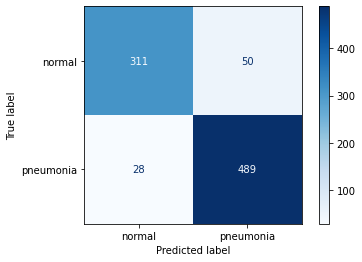

model_29 performance:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       361
           1       0.90      0.95      0.92       517

    accuracy                           0.91       878
   macro avg       0.91      0.90      0.90       878
weighted avg       0.91      0.91      0.91       878



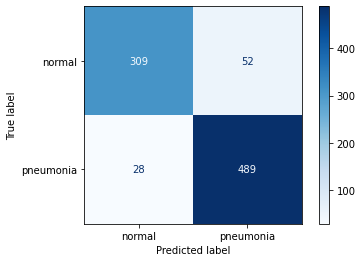

model_14 performance:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       361
           1       0.91      0.93      0.92       517

    accuracy                           0.91       878
   macro avg       0.91      0.90      0.90       878
weighted avg       0.91      0.91      0.91       878



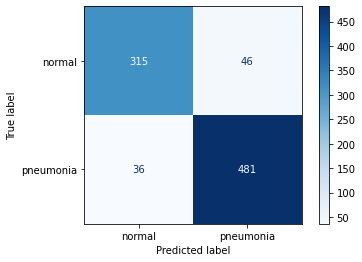

model_20 performance:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       361
           1       0.89      0.95      0.92       517

    accuracy                           0.90       878
   macro avg       0.91      0.89      0.90       878
weighted avg       0.91      0.90      0.90       878



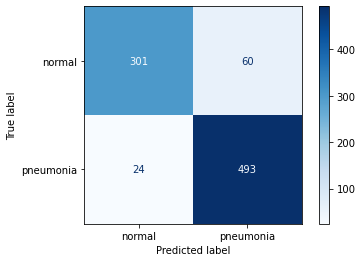

model_19 performance:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       361
           1       0.89      0.94      0.91       517

    accuracy                           0.90       878
   macro avg       0.90      0.88      0.89       878
weighted avg       0.90      0.90      0.89       878



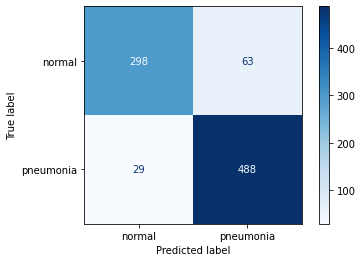

model_13 performance:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       361
           1       0.90      0.92      0.91       517

    accuracy                           0.89       878
   macro avg       0.89      0.89      0.89       878
weighted avg       0.89      0.89      0.89       878



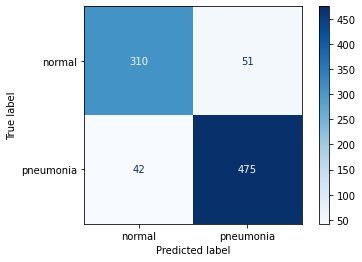

model_30 performance:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       361
           1       0.89      0.93      0.91       517

    accuracy                           0.89       878
   macro avg       0.89      0.88      0.89       878
weighted avg       0.89      0.89      0.89       878



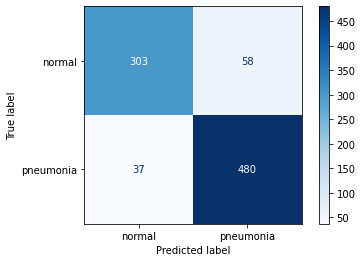

model_32 performance:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85       361
           1       0.87      0.96      0.91       517

    accuracy                           0.89       878
   macro avg       0.90      0.87      0.88       878
weighted avg       0.89      0.89      0.89       878



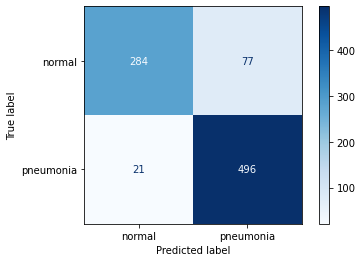

model_16 performance:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       361
           1       0.93      0.87      0.90       517

    accuracy                           0.88       878
   macro avg       0.88      0.89      0.88       878
weighted avg       0.89      0.88      0.88       878



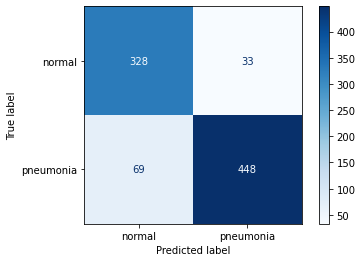

model_22 performance:
              precision    recall  f1-score   support

           0       0.89      0.81      0.84       361
           1       0.87      0.93      0.90       517

    accuracy                           0.88       878
   macro avg       0.88      0.87      0.87       878
weighted avg       0.88      0.88      0.88       878



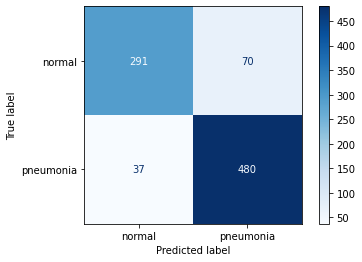

In [50]:
# Loop through each model and call the scores function
for model in top_models:
    
    # Models between 17-25 were run on enhanced images and therefore need to evaluated on those images
    version = int(model[6:])
    if (version >=17) & (version<=25):
        gen = tuning_gen_en
    else:
        gen = tuning_gen
    print(model + ' performance:')
    
    # Load the model and call the scores function
    model = keras.models.load_model('models/{}'.format(model))
    scores(model, gen)

<u>False Positives:</u> Most of our best models above had similar number of false positives in the 20s, though a few did have 40-60 false positives.  Either way, considering false positives does not make a significant impact in deciding which model should be the final model. 

<u>Accuracy Scores:</u> In the top 10 models we have accuracy scores that range from 87-91%, only a 4% range.  This 4% difference in accuracy scores pales in comparison to the variability in accuracy scores epoch to epoch when in the training these models.  It is important to recall that we set up this models to save the weights of only best round of training.  That means that even though our scores are high, the model may not be generalizing very well for new data.  Ideally we would have a model that improves consistently until some point in training when it starts to overfit towards the training data and the accuracy on the tuning set plateaues and then declines.  For this reason, it's a better idea to pick one of these models with the most consistent tuning accuracies rather than a model the produced the best accuracy for one round of training.

$M_{32}$ had the most consistent training and it's accuracy remained between 85-88% for most of the training epochs.  Other models such as $M_{33}$ did produce tuning accuracies in the 90%'s but often fluctuated with training rounds reaching tuning accuracies often in the low 80s 70s and sometimes 60s. For this reason$M_{32}$ generalizes the data the best and will be evaluated on the hold-out (validation) set.

## Final Model Validation
___
We'll start by testing our final model ($M_{32}$) on the hold-out (validation) set.

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       439
           1       0.93      0.90      0.92       439

    accuracy                           0.92       878
   macro avg       0.92      0.92      0.92       878
weighted avg       0.92      0.92      0.92       878



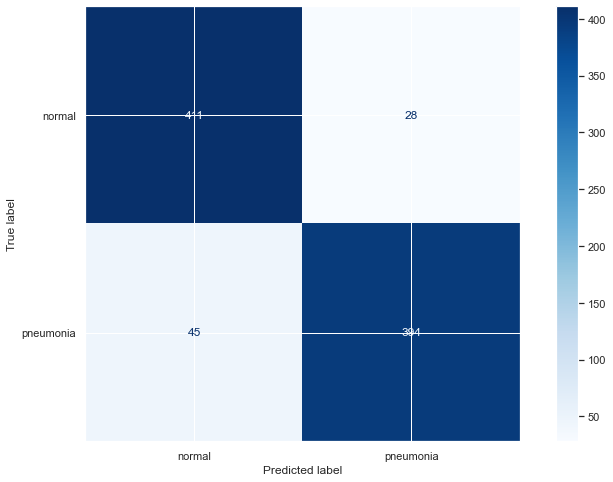

In [42]:
# Load the final model and test on the validation set
final_model = keras.models.load_model('models/model_32')
scores(final_model, val_gen)

**Validation Test Results**:
Great! The good news is the final model overall accuracy improved from our test using the tuning set.  However, it also classified 45 people as false negatives (5%) which is up from the 28 false negatives when tested on the tuning data. The model was 93% precise with pneumonia predictions (correctly classified pneumonia with 93% accuracy) and 90% precise with normal predictions. Over all the model correctly labeled 94% of normal patients, 90% of pneumonia patients, for an overall accuracy of 92%.<br><br>
**Improvement**:
Where this model could improve is reducing those 45 false negatives. These are people who will not receive a pneumonia diagnosis and consequently treatment for their infection due to their missclassification by the model.  The model will need to be further improved with either more tuning, architectural changes, more images to train on, or all of the above.

Now let try to visualize the activation functions within our neural network to see if we can uncover any other insights.

In [53]:
# Get the final model predictions
preds = final_model.predict(val_gen)
preds[preds>=.5] = 1
preds[preds<.5] = 0

# Find a pneumonia image that the model predicted correctly (last image in val_pneumonia set)
print('Last image in val_pneumonia set was predicted correctly:', preds[-1] == val_gen.labels[-1])

Last image in val_pneumonia set was predicted correctly: [ True]


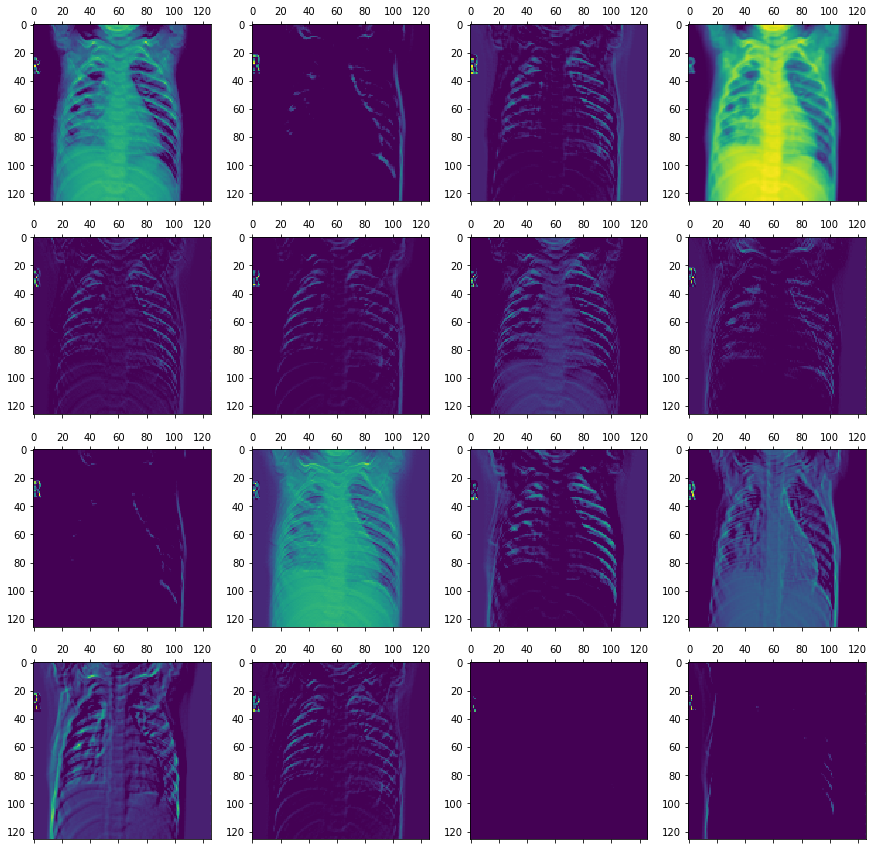

In [110]:
# Import and reshape image for visualization of activation functions
image = PIL.Image.open("chest_xray/val/PNEUMONIA/{}".format(val_pneum[-1]))
image = image.resize((128,128))
img_tensor = np.array(image)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = img_tensor/255

# Extract model layer outputs and create model to display feature maps
layer_outputs = [layer.output for layer in final_model.layers[:6]]
activation_model = keras.models.Model(inputs=final_model.input, outputs= layer_outputs)
activations = activation_model.predict(img_tensor)

# Visualize first layer feature map
first_layer_activation = activations[0]
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i in range(16):
    row = (i)//4
    col = (i)%4
    ax = axes[row][col]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

Above is the feature map output from the first conv2d layer of our model.  Since I am not a radiologist, I cannot definitively say whether or not the model is highlighting the features that indicate the presence of pneumonia. But, if shown to a radiologist, they could probably confirm which of these appears to highlight pneumonia and which are just random noise.  Evaluation with a radiologist would be a great way to improve this model in the future.

**Area Under the Curve** - Next let's look at the AUC to get a sense for how the model's true positive and false positive rates look for each decision threshold. I'll start by defining a function to plot the auc

In [115]:
def auc_plot(model, gen):
    '''
    Plot the roc curve given the model and the validation data
    
    PARAMETERS
    ----------
    model - Sequential() keras model, trained
    gen - ImageDataGenerator, pre-instantiated with data
    '''
    # Use 
    prob = model.predict(gen)
    
    fpr, tpr, thresholds =  roc_curve(gen.labels, prob)
    
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    print('Model AUC:',round(auc(fpr, tpr),3))

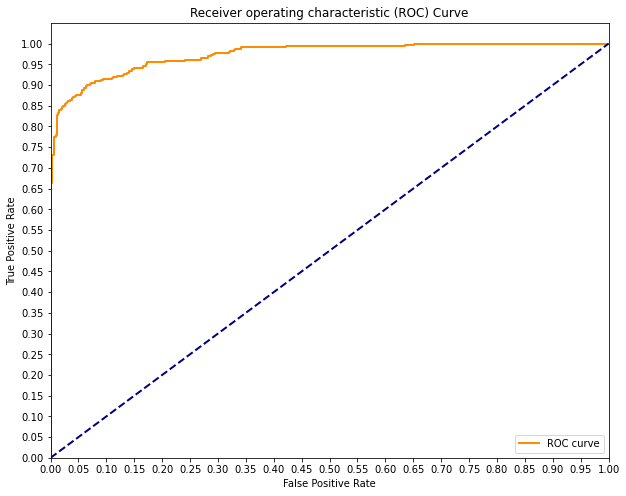

Model AUC: 0.974


In [116]:
auc_plot(final_model, val_gen)

As shown in the above plot, the auc is 0.974 which is pretty good.  The decision threshold of 0.5 gave us a true positive rate of 0.9 which does appear about as close as possible to the top left corner of the plot as possible - meaning that our trade off between true positives and false positives is balanced.  If we increased the decision threshold to get more true positives, we would clearly also gain a whole lot more false positives.

Now, let's plot Specificity (True Negative Rate) and Sensativity (True Positive Rate) against the decision thresholds.  Specificity and sensativity will show the tradeoff between obtaining more true positives for decreased true negatives and vice versa. I'll start by defining a fuction `tpr_tnr()` to the TPR and TNR for each decision threshold input to the function.

In [99]:
def tpr_tnr(preds, thresholds):
    '''
    Get the true negatives for each threshold given the threshold and predictions
    
    PARAMETERS
    -----------
    preds - float, output predictions from the given model
    thresholds - floats, 
    '''
    specificity = []
    sensitivity = []

    # For each threshold
    for t in thresholds:

        # Classify predictions as either 0 or 1
        temp_preds = preds.copy()
        temp_preds[temp_preds>=t]=1
        temp_preds[temp_preds<t]=0

        # Calculate Confusion Matrix
        cm = confusion_matrix(val_gen.labels, temp_preds)
        tp_pp = cm[0][0]
        tp_pn = cm[0][1]
        tn_pp = cm[1][0]
        tn_pn = cm[1][1]

        # Calculate True negative rate and append to list
        specificity.append((tn_pn)/(tn_pn + tn_pp))
        sensitivity.append(tp_pp/(tp_pp + tp_pn))
    return specificity, sensitivity

In [103]:
# Get the raw predictions from the model
prob = final_model.predict(val_gen)

# Define thresholds for ploting 
thresholds = np.linspace(.01,1,100)

# Get the specificity and sensativities using above function
specificity, sensativity = tpr_tnr(prob, thresholds)

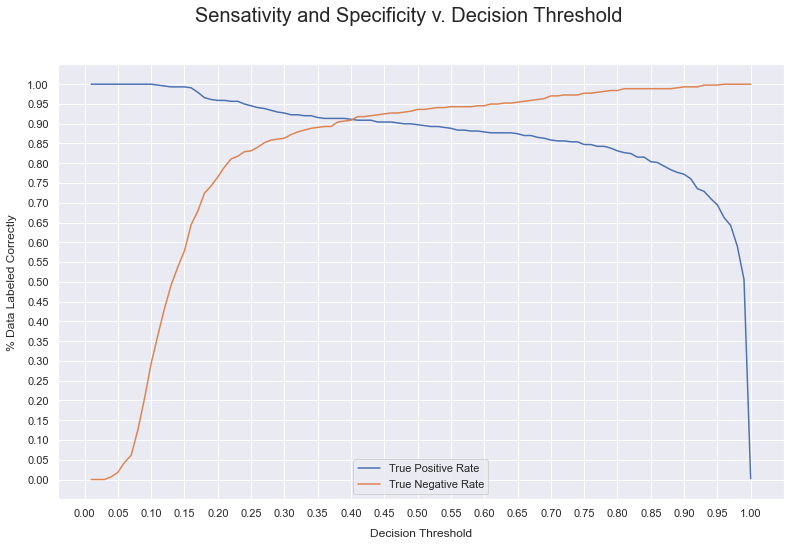

In [115]:
# Create plot showing Sensativity and Specificity v. Decision Threshold
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(13,8)})
fig = plt.figure()
plt.plot(thresholds, specificity)
plt.plot(thresholds, sensativity)
plt.ylabel('% Data Labeled Correctly', labelpad=10)
plt.xlabel('Decision Threshold',labelpad=10)
plt.legend(['True Positive Rate','True Negative Rate'])
plt.yticks(np.linspace(0, 1, 21))
plt.xticks(np.linspace(0, 1, 21));
fig.suptitle('Sensativity and Specificity v. Decision Threshold', fontsize=20);


Shows the trade-off between number of correctly classified true positives and true negatives if you move the decision threshold value.  At the selected decision threshold 0.5, the model has a true positive rate of 90% and a true negative ratse of 94%.  Increasing the number true positive by decreasing the decision threshold would clearly result in losing more true negatives.

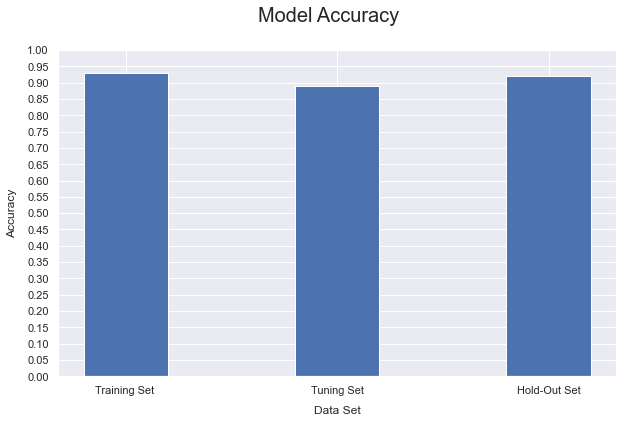

In [90]:
# Create barplot showing accuracy
fig = plt.figure()
sns.set(rc = {'figure.figsize':(10,6)})
plt.bar(x=['Training Set ', 'Tuning Set', 'Hold-Out Set'], height = [0.93, 0.89, 0.92],width=.4)
plt.ylabel('Accuracy', labelpad=10)
plt.xlabel('Data Set', labelpad=10);
plt.yticks(np.linspace(0, 1, 21));
fig.suptitle('Model Accuracy', fontsize=20);

The above barplot shows the accuracies achieved by the final model when tested on each set of data.  The model achieved a greatest accuracy of 94% on the training set as expected.  The model performed at 89% accuracy on the tuning set. The model actually performed better on the hold-out set than on the tuning set which is an indication that the model did generalize well with a 92% accuracy.  Also important to note that the hold-out set and the validation set are the same size (898 samples) and therefore equally reliable.